In [1]:
!nvidia-smi

Thu Apr 22 00:19:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3
!pip install torch

     |████████████████████████████████| 46.9MB 66kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 348kB 19.5MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595684 sha256=92d39511819b600a401af67e4f3b3e587240bf6d751f75ee2a8c7d34af095150
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
     |████████████████████████████████| 1.2MB 20.1MB/s 
     |████████████████████████████████| 757kB 18.3MB/s 
     |████████████████████████████████| 3.0MB 53.2MB/s 
     |████████████████████████████████| 901kB 56.3MB/s 


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
from tqdm import tqdm, tqdm_notebook, notebook

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)
device = torch.device("cuda:0")

Thu Apr 22 00:20:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
##GPU 사용 시
device = torch.device("cuda:0")

In [136]:
torch.cuda.is_available()

True

In [7]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-obupej4z
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-obupej4z
  Created wheel for kobert: filename=kobert-0.1.2-cp37-none-any.whl size=12708 sha256=e386bb3207fc6fafe6880dcabe9040efea39213ba0995baaac42dc06d7155303
  Stored in directory: /tmp/pip-ephem-wheel-cache-mdlrqk25/wheels/a2/b0/41/435ee4e918f91918be41529283c5ff86cd010f02e7525aecf3
Successfully built kobert


In [8]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
from gluonnlp.data import SentencepieceTokenizer

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import random
import time
import datetime

In [10]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [11]:
BASE_PATH = '/gdrive/MyDrive/etc/will'
# data_2019 = glob.glob(BASE_PATH + '/*') # + '*'

In [ ]:
import os
os.listdir(BASE_PATH)
# os.chdir()
# os.getcwd()

In [14]:
bertmodel, vocab = get_pytorch_kobert_model()

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]


In [ ]:
bertmodel

In [15]:
from ast import literal_eval
# https://stackoverflow.com/questions/32742976/how-to-read-a-column-of-csv-as-dtype-list-using-pandas

In [ ]:
df1 = pd.read_csv(BASE_PATH+'/202011.csv', index_col=[0], encoding="utf-8", converters={"x": literal_eval, "text2": literal_eval}) #dtype=np.object)

In [17]:
df1 = pd.read_csv(BASE_PATH+'/dff_중복제거.csv', index_col=[0], encoding="cp949", dtype=np.object) #dtype=np.object)
df1.head(3)

,isbn,name,toc,text,n5,n2
category,,,,,,
1001009,9.78893E+12,나는 미생물과 산다,프롤로그 1부 미생물이 뿔났다 미생물 명예 회복 대책 회의 1차 미생물 명예 회복 ...,조류독감 구제역 사스 메르스 세상에 나쁜 세균만 있는 것은 아니다 그런데 왜 인간은...,340,4
1001009,9.79119E+12,나우 시간의 물리학,머리말 1부 시간의 놀라움 얽혀 있는 수수께끼 동심으로 돌아간 아인슈타인 동에 번쩍...,풀리지 않는 물리학의 최대 수수께끼 시간은 흐르는가 흐르지 않는가 만약 누가 나에게...,9342,4
1001002,9.7912E+12,진단이라는 신약,제 장 조기진단 메틸화 바이오마커와 받지 않는다 조기진단 돈과 보험 미국 콜로가드 ...,암세포를 죽이는 것을 넘어서 암 환자를 살려내는 진단 암을 쉽고 빠르게 찾고 환자에...,347,4


In [47]:
df1 = pd.read_csv(BASE_PATH+'/dff.csv', index_col=[0], encoding="cp949", dtype={'category':np.object, 'isbn':int, 'n5':np.object}) #dtype=np.object)
df1.head(3)

,category,isbn,name,toc,text,n5,n2
0,1001009.0,9788932473789,나는 미생물과 산다,프롤로그 1부 미생물이 뿔났다 미생물 명예 회복 대책 회의 1차 미생물 명예 회복 ...,조류독감 구제역 사스 메르스 세상에 나쁜 세균만 있는 것은 아니다 그런데 왜 인간은...,0340,4
1,1001009.0,9791189932176,나우 시간의 물리학,머리말 1부 시간의 놀라움 얽혀 있는 수수께끼 동심으로 돌아간 아인슈타인 동에 번쩍...,풀리지 않는 물리학의 최대 수수께끼 시간은 흐르는가 흐르지 않는가 만약 누가 나에게...,9342,4
2,1001002.0,9791196079390,진단이라는 신약,제 장 조기진단 메틸화 바이오마커와 받지 않는다 조기진단 돈과 보험 미국 콜로가드 ...,암세포를 죽이는 것을 넘어서 암 환자를 살려내는 진단 암을 쉽고 빠르게 찾고 환자에...,0347,4


In [19]:
df2019 = pd.read_csv(BASE_PATH+'/dff_2019.csv', index_col=[0], encoding="utf-8", dtype=np.object) #dtype=np.object)
df2019.head(3)

,category,isbn,name,toc,text,n5
1,1001001,9791164136957,닥터앤닥터 육아일기,닥터 베르 닥터 안다 신생아 돌보기 역지사지 역지사지 엄마 닥터 아빠 닥터 아빠 닥...,임신 출산 육아를 준비 중인 그리고 한창 진행 중인 이 시대의 모든 가족을 응원합니...,0737
3,1001001,9791196848194,수학 잘하는 아이는 이렇게 공부합니다,추천사 생각의 힘을 기르는 진짜 수학 공부 프롤로그 고등 수학을 잘하기 위한 올바른...,초등 수학 잘하던 아이 고등 성적 떨어지면 무슨 소용 있나요 어렵고 불안한 수학 엄...,0337
6,1001001,9791130636429,초등 엄마 거리두기 법칙,프롤로그 엄마의 거리두기로 아이가 홀로 설 수 있는 힘을 길러주세요 엄마의 거리두기...,불안한 엄마는 사사건건 개입하지만 현명한 엄마는 거리를 두고 기다려줍니다 초등 교사...,1337


In [20]:
df2018 = pd.read_csv(BASE_PATH+'/dff_2018.csv', index_col=[0], encoding="utf-8", dtype=np.object) #dtype=np.object)
df2018.head(3)

,category,isbn,name,toc,text,n5
1,1001001,9791164136957,닥터앤닥터 육아일기,닥터 베르 닥터 안다 신생아 돌보기 역지사지 역지사지 엄마 닥터 아빠 닥터 아빠 닥...,임신 출산 육아를 준비 중인 그리고 한창 진행 중인 이 시대의 모든 가족을 응원합니...,0737
3,1001001,9791196848194,수학 잘하는 아이는 이렇게 공부합니다,추천사 생각의 힘을 기르는 진짜 수학 공부 프롤로그 고등 수학을 잘하기 위한 올바른...,초등 수학 잘하던 아이 고등 성적 떨어지면 무슨 소용 있나요 어렵고 불안한 수학 엄...,0337
7,1001001,9791160075908,널리케이크의 한식 디저트 클래스,프롤로그 한식 디저트를 만들기 전에 도구 기본 도구 모양내는 도구 재료 주재료 곡류...,예쁘고 건강하고 맛있는 우리 떡 한과 퓨전 디저트 인기 디저트 공방 널리케이크 가 ...,1359


In [23]:
tt = df2018.reset_index()
del tt['index']
tt.head(2)

,category,isbn,name,toc,text,n5
0,1001001,9791164136957,닥터앤닥터 육아일기,닥터 베르 닥터 안다 신생아 돌보기 역지사지 역지사지 엄마 닥터 아빠 닥터 아빠 닥...,임신 출산 육아를 준비 중인 그리고 한창 진행 중인 이 시대의 모든 가족을 응원합니...,0737
1,1001001,9791196848194,수학 잘하는 아이는 이렇게 공부합니다,추천사 생각의 힘을 기르는 진짜 수학 공부 프롤로그 고등 수학을 잘하기 위한 올바른...,초등 수학 잘하던 아이 고등 성적 떨어지면 무슨 소용 있나요 어렵고 불안한 수학 엄...,0337


In [24]:
ttt = df2019.reset_index()
del ttt['index']
ttt.head(2)

,category,isbn,name,toc,text,n5
0,1001001,9791164136957,닥터앤닥터 육아일기,닥터 베르 닥터 안다 신생아 돌보기 역지사지 역지사지 엄마 닥터 아빠 닥터 아빠 닥...,임신 출산 육아를 준비 중인 그리고 한창 진행 중인 이 시대의 모든 가족을 응원합니...,0737
1,1001001,9791196848194,수학 잘하는 아이는 이렇게 공부합니다,추천사 생각의 힘을 기르는 진짜 수학 공부 프롤로그 고등 수학을 잘하기 위한 올바른...,초등 수학 잘하던 아이 고등 성적 떨어지면 무슨 소용 있나요 어렵고 불안한 수학 엄...,0337


In [27]:
tt['n100'] = tt['n5']
tt['n10'] = tt['n5']
for i in range(len(tt)):
    tt['n100'][i] = tt['n100'][i][-2:-1]
    tt['n10'][i] = tt['n10'][i][-2:]

In [28]:
tt.tail(2)

,category,isbn,name,toc,text,n5,n100,n10
8468,1001047,9788954756457,신계숙의 일단 하는 인생,프롤로그 계향각에서 식전 차를 마시며 1장 아프니까 아프기만 하던데 양장피를 만들 ...,오늘 하고 싶은 일을 내일로 미루지 않는 신계숙의 인생 참맛 도전기 2020년 4월...,0381,8,81
8469,1001047,9791196545529,기억의 범람,길 위에서 사랑으로 까만 새벽 밝은 밤,무엇을 쓰냐고 물으면 사랑을 쓰고 있다고 답할 만큼 주로 자전적 사랑 이야기를 쓰는...,0380,8,80


In [31]:
ttt['n100'] = ttt['n5']
ttt['n10'] = ttt['n5']
for i in range(len(ttt)):
    ttt['n100'][i] = ttt['n100'][i][-2:-1]
    ttt['n10'][i] = ttt['n10'][i][-2:]

In [32]:
ttt.tail(2)

,category,isbn,name,toc,text,n5,n100,n10
8469,1001047,9791170222200,제 코가 석 자입니다만,지은이의 말 1장 아아 제가 가장 걱정입니다 내가 제일 걱정이다 빠른 년생이 어때서...,내 코가 석자여서 내가 걱정해주지 않으면 안 되는 내 인생 오늘도 내일도 내가 제일...,0381,8,81
8470,1001047,9791137237810,내 아이의 첫 선생님,삶으로서의 수업 1학년 6학년 협력학습 여덟 살 책을 쓰다 맨발걷기 교육을 하다 선...,첫아이를 학교에 보내놓고 노심초사하는 부모님과 1학년 교사로서의 한해살이가 두려운 ...,0381,8,81


In [48]:
tttt = df1.reset_index()

In [ ]:
tttt.tail(2)

In [50]:
del tttt['index']
del tttt['n2']

In [ ]:
tttt.head(3)

In [52]:
tttt['n100'] = tttt['n5']
tttt['n10'] = tttt['n5']
for i in range(len(tttt)):
    tttt['n100'][i] = tttt['n100'][i][-2:-1]
    tttt['n10'][i] = tttt['n10'][i][-2:]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [53]:
tttt.head(2)

,category,isbn,name,toc,text,n5,n100,n10
0,1001009.0,9788932473789,나는 미생물과 산다,프롤로그 1부 미생물이 뿔났다 미생물 명예 회복 대책 회의 1차 미생물 명예 회복 ...,조류독감 구제역 사스 메르스 세상에 나쁜 세균만 있는 것은 아니다 그런데 왜 인간은...,0340,4,40
1,1001009.0,9791189932176,나우 시간의 물리학,머리말 1부 시간의 놀라움 얽혀 있는 수수께끼 동심으로 돌아간 아인슈타인 동에 번쩍...,풀리지 않는 물리학의 최대 수수께끼 시간은 흐르는가 흐르지 않는가 만약 누가 나에게...,9342,4,42


In [54]:
res1 = pd.concat([tt, ttt, tttt])

In [56]:
res_save = res1.reset_index()

In [58]:
del res_save['index']

In [60]:
res_save.tail(2)

,category,isbn,name,toc,text,n5,n100,n10
37828,1001047,9791186198599,빈칸 책,나의 탄생 나의 성질 나의 얼굴 나의 단어 나의 뇌구조 나의 손 나의 이름 나의 헤...,빈칸 책 은 말 그대로 빈칸 으로 가득한 책이다 빈칸 이 존재하는 까닭은 채워지기 ...,0380,8,80
37829,1001047,9791162850480,사는 게 쉽다면 아무도 꿈꾸지 않았을 거야,작가의 말 당신의 꿈은 뭐예요 1부 사소하게 반복되는 행복이 꿈이 된다 두 사람과 ...,한국의 장자크 상페를 꿈꾸는 일러스트레이터 다인 또래 친구들이 공부하는 데 열심일 ...,0381,8,81


In [61]:
res_save.isnull().sum()

category    0
isbn        0
name        0
toc         0
text        0
n5          0
n100        0
n10         0
dtype: int64

In [63]:
g1 = res_save.groupby('n100')
g1.count()

,category,isbn,name,toc,text,n5,n10
n100,,,,,,,
0,3390,3390,3390,3390,3390,3390,3390
1,2633,2633,2633,2633,2633,2633,2633
2,2547,2547,2547,2547,2547,2547,2547
3,6933,6933,6933,6933,6933,6933,6933
4,3122,3122,3122,3122,3122,3122,3122
5,3636,3636,3636,3636,3636,3636,3636
6,3891,3891,3891,3891,3891,3891,3891
7,694,694,694,694,694,694,694
8,6854,6854,6854,6854,6854,6854,6854


In [64]:
g1 = res_save.groupby('n10')
g1.count()

,category,isbn,name,toc,text,n5,n100
n10,,,,,,,
00,3053,3053,3053,3053,3053,3053,3053
01,14,14,14,14,14,14,14
02,9,9,9,9,9,9,9
03,52,52,52,52,52,52,52
04,20,20,20,20,20,20,20
...,...,...,...,...,...,...,...
94,42,42,42,42,42,42,42
95,14,14,14,14,14,14,14
96,28,28,28,28,28,28,28


In [65]:
res_save.duplicated().sum()

7568

In [66]:
fin = res_save.drop_duplicates(subset='isbn', keep="last")
fin.duplicated().sum()

0

In [68]:
len(fin)

27035

In [69]:
fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27035 entries, 16 to 37829
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  27035 non-null  object
 1   isbn      27035 non-null  object
 2   name      27035 non-null  object
 3   toc       27035 non-null  object
 4   text      27035 non-null  object
 5   n5        27035 non-null  object
 6   n100      27035 non-null  object
 7   n10       27035 non-null  object
dtypes: object(8)
memory usage: 1.9+ MB


In [70]:
g2 = fin.groupby('n10')
g2.count()

,category,isbn,name,toc,text,n5,n100
n10,,,,,,,
00,1868,1868,1868,1868,1868,1868,1868
01,11,11,11,11,11,11,11
02,8,8,8,8,8,8,8
03,38,38,38,38,38,38,38
04,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...
94,29,29,29,29,29,29,29
95,11,11,11,11,11,11,11
96,19,19,19,19,19,19,19


  n100  count
0    0   2139
1    1   1973
2    2   1776
3    3   5213
4    4   2101
5    5   2732
6    6   2629
7    7    519
8    8   5103
9    9   2850


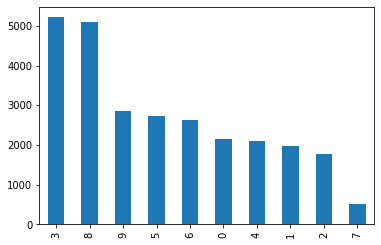

In [72]:
fin['n100'].value_counts().plot(kind = 'bar')
print(fin.groupby('n100').size().reset_index(name = 'count'))

In [73]:
fin.to_csv(
    BASE_PATH + '/210422_first.csv',
    index=False
)

In [77]:
tdf = fin.copy()

In [79]:
tdf.head(1)

,category,isbn,name,toc,text,n5,n100,n10
16,1001001,9791125495970,민주선생님 똑소리나는 육아 우리 아이 훈육편,훈육 바로알기 들어가기 훈육의 개념 정리 훈육의 적절한 시기 훈육 실패하지 않기 위...,부모는 육아를 위해 끊임없이 고민합니다 그런 과정을 통해 아이가 크는 만큼 부모도 ...,1359,5,59


In [83]:
tdf['x'] = tdf['name'] + " " + tdf['toc'] + " " + tdf['text']
# for i in range(len(tdf)):


In [84]:
tdf['x']

16       민주선생님 똑소리나는 육아 우리 아이 훈육편 훈육 바로알기 들어가기 훈육의 개념 정...
247      진짜 칭찬 들어가는 말 그 좋다는 칭찬에 우리는 왜 인색할까요 1장 칭찬이 내 아이...
342      반찬 없이도 테이블이 완벽해지는 솥밥 저자의 말 쌀의 종류 솥의 종류 육수 만들기 ...
348      세상에서 제일 쉬운 엄마표 영어놀이 머리말 엄마표 선배맘 5인의 추천평 모든 아이들...
355      초등 사춘기 엄마를 이기는 아이가 세상을 이긴다 추천사 행복한 사춘기를 위한 초등교...
                               ...                        
37825    모두의 독서모임 들어가는 말 이진영 내게는 소중한 독서모임 경험 독서모임으로 무언가...
37826    선생님 또 어디 가요 머리말 그래서 저는 또 여행을 합니다 70억 분의 기적 같은 ...
37827    헛어른 프롤로그 서른이면 어른인 줄 알았는데 1장 서른이라 그래요 호기심 나잇값 외...
37828    빈칸 책 나의 탄생 나의 성질 나의 얼굴 나의 단어 나의 뇌구조 나의 손 나의 이름...
37829    사는 게 쉽다면 아무도 꿈꾸지 않았을 거야 작가의 말 당신의 꿈은 뭐예요 1부 사소...
Name: x, Length: 27035, dtype: object

In [86]:
tdf = tdf.reset_index(drop=True)
tdf['x']

0        민주선생님 똑소리나는 육아 우리 아이 훈육편 훈육 바로알기 들어가기 훈육의 개념 정...
1        진짜 칭찬 들어가는 말 그 좋다는 칭찬에 우리는 왜 인색할까요 1장 칭찬이 내 아이...
2        반찬 없이도 테이블이 완벽해지는 솥밥 저자의 말 쌀의 종류 솥의 종류 육수 만들기 ...
3        세상에서 제일 쉬운 엄마표 영어놀이 머리말 엄마표 선배맘 5인의 추천평 모든 아이들...
4        초등 사춘기 엄마를 이기는 아이가 세상을 이긴다 추천사 행복한 사춘기를 위한 초등교...
                               ...                        
27030    모두의 독서모임 들어가는 말 이진영 내게는 소중한 독서모임 경험 독서모임으로 무언가...
27031    선생님 또 어디 가요 머리말 그래서 저는 또 여행을 합니다 70억 분의 기적 같은 ...
27032    헛어른 프롤로그 서른이면 어른인 줄 알았는데 1장 서른이라 그래요 호기심 나잇값 외...
27033    빈칸 책 나의 탄생 나의 성질 나의 얼굴 나의 단어 나의 뇌구조 나의 손 나의 이름...
27034    사는 게 쉽다면 아무도 꿈꾸지 않았을 거야 작가의 말 당신의 꿈은 뭐예요 1부 사소...
Name: x, Length: 27035, dtype: object

In [144]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [145]:
!!pip install kiwipiepy
from kiwipiepy import Kiwi, Option
kiwi = Kiwi(options=Option.DEFAULT)
kiwi.prepare()

0

In [147]:
def tokenize(sent, debug=False):
    res, score = kiwi.analyze(sent)[0] # 첫번째 결과를 사용
    ret = []
    if debug:
      print(res)
    for word, tag, _, _ in res:
        # 조사, 어미, 특수기호 및 stopwords에 포함된 단어는 제거
        if (tag.startswith('N') and
            not tag.startswith('NNB') and
            not tag.startswith('NP') and
            not tag.startswith('E') and
            not tag.startswith('J') and
            not tag.startswith('S') # and
            ): #word not in dlist
          # ret.append(word + ('다' if tag.startswith('V') else ''))
          ret.append(word)
    return ret


In [148]:
import timeit
start = timeit.default_timer()

X_train = []
for sentence in tdf['x']:
    temp_X = []
    temp_X = tokenize(sentence) # 토큰화
    X_train.append(temp_X)
end = timeit.default_timer()

print('Elapsed time', end - start)

Elapsed time 3551.1039824630006


In [149]:
np.save('toc.npy',X_train)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [151]:
len(tdf)

27035

In [ ]:
# # 단어 길이가 2 이상인 애들로만

# for idx, i in enumerate(X_train):
#   i = [elem for elem in i if len(elem)>=2]
#   X_train[idx] = i

In [150]:
tdf['ready'] = X_train

In [ ]:
tdf.head(2)

In [ ]:
# import timeit
# start = timeit.default_timer()

# X_new = []
# for sentence in tdf['x']:
#     # tttt = []
#     # sentence = sentence.split(',')
#     # for tmps in sentence:
#         # tt = tmps.strip("'")
#         # tttt.append(tt)
#     X_new.append(' '.join(sentence))
# end = timeit.default_timer()

# elapsed = end - start
# if elapsed >= 60:
#     print('Elapsed time', elapsed/60)

In [156]:
import timeit
start = timeit.default_timer()

X_new = []
for sentence in tdf['ready']:
    # tttt = []
    # sentence = sentence.split(',')
    # for tmps in sentence:
        # tt = tmps.strip("'")
        # tttt.append(tt)
    X_new.append(' '.join(sentence))
end = timeit.default_timer()

elapsed = end - start
if elapsed >= 60:
    print('Elapsed time', elapsed/60)

In [157]:
tdf['input'] = X_new

In [ ]:
# tdf.to_csv

In [209]:
tdf.head(2)

,category,isbn,name,toc,text,n5,n100,n10,x,ready,input
0,1001001,9791125495970,민주선생님 똑소리나는 육아 우리 아이 훈육편,훈육 바로알기 들어가기 훈육의 개념 정리 훈육의 적절한 시기 훈육 실패하지 않기 위...,부모는 육아를 위해 끊임없이 고민합니다 그런 과정을 통해 아이가 크는 만큼 부모도 ...,1359,5,59,민주선생님 똑소리나는 육아 우리 아이 훈육편 훈육 바로알기 들어가기 훈육의 개념 정...,"[민주, 선생, 소리, 육아, 아이, 훈육, 편, 훈육, 훈육, 개념, 정리, 훈육...",민주 선생 소리 육아 아이 훈육 편 훈육 훈육 개념 정리 훈육 시기 훈육 실패 지침...
1,1001001,9791188915422,진짜 칭찬,들어가는 말 그 좋다는 칭찬에 우리는 왜 인색할까요 1장 칭찬이 내 아이를 키운다 ...,칭찬의 효과와 역효과 그리고 진짜 칭찬의 기술까지 칭찬에 대한 모든 것을 알려주는 ...,0359,5,59,진짜 칭찬 들어가는 말 그 좋다는 칭찬에 우리는 왜 인색할까요 1장 칭찬이 내 아이...,"[칭찬, 말, 칭찬, 인색, 장, 칭찬, 아이, 성공, 실패, 칭찬, 힘, 칭찬, ...",칭찬 말 칭찬 인색 장 칭찬 아이 성공 실패 칭찬 힘 칭찬 힘 동기 자극 언어 보상...


In [210]:
tdf.tail(2)

,category,isbn,name,toc,text,n5,n100,n10,x,ready,input
27033,1001047,9791186198599,빈칸 책,나의 탄생 나의 성질 나의 얼굴 나의 단어 나의 뇌구조 나의 손 나의 이름 나의 헤...,빈칸 책 은 말 그대로 빈칸 으로 가득한 책이다 빈칸 이 존재하는 까닭은 채워지기 ...,0380,8,80,빈칸 책 나의 탄생 나의 성질 나의 얼굴 나의 단어 나의 뇌구조 나의 손 나의 이름...,"[빈칸, 책, 탄생, 성질, 얼굴, 단어, 뇌, 구조, 손, 이름, 헤어스타일, 욕...",빈칸 책 탄생 성질 얼굴 단어 뇌 구조 손 이름 헤어스타일 욕실 사진 식도락 잠 냄...
27034,1001047,9791162850480,사는 게 쉽다면 아무도 꿈꾸지 않았을 거야,작가의 말 당신의 꿈은 뭐예요 1부 사소하게 반복되는 행복이 꿈이 된다 두 사람과 ...,한국의 장자크 상페를 꿈꾸는 일러스트레이터 다인 또래 친구들이 공부하는 데 열심일 ...,0381,8,81,사는 게 쉽다면 아무도 꿈꾸지 않았을 거야 작가의 말 당신의 꿈은 뭐예요 1부 사소...,"[작가, 말, 꿈, 반복, 행복, 꿈, 사람, 하나, 꿈, 골목, 꿈, 강아지, 팔...",작가 말 꿈 반복 행복 꿈 사람 하나 꿈 골목 꿈 강아지 팔 불 출 강물 색깔 심리...


In [208]:
tdf.to_csv(
    BASE_PATH + '/210422_second.csv',
    index=False
)

In [158]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(tdf[['input']], tdf['n100'],
                                          test_size = 0.2,
                                          shuffle=True,
                                          stratify=tdf['n100'],
                                          random_state=2013)
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

21628
21628
5407
5407


In [87]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(tdf[['x']], tdf['n100'],
                                          test_size = 0.2,
                                          shuffle=True,
                                          stratify=tdf['n100'],
                                          random_state=2013)
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

21628
21628
5407
5407


21628


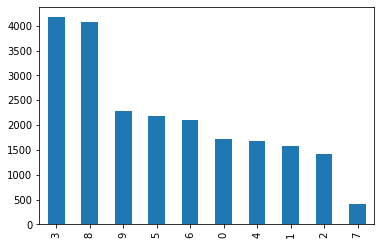

In [154]:
trainY.value_counts().plot(kind = 'bar')
print(trainY.size)

In [159]:
# 문장 추출
sentences = trainX['input'].values
# sentences[:10]
train_dataset = pd.DataFrame({'sentence': sentences, 'label': trainY}, columns=['sentence', 'label'])

# 문장 추출
sentences = testX['input'].values
test_dataset = pd.DataFrame({'sentence': sentences, 'label': testY}, columns=['sentence', 'label'])
sentences[:10]

array(['크툴루 부름 수호자 룰 북 목차 소개 개요 플레이 예 플레이 필요 장 러브크래프트 크툴루 신화 하워드 필립스 러브크래프 크툴루 신화 장 탐사 참조 탐사 숫자 의미 하비 월터스 소개 직업 예 절반 값 값 참고 표 장 기능 기능 목록 장 시스템 기능 판정 보너스 주사위 페널티 주사위 탐사 성장 관리 단계 장 전투 전투 라운드 전투 무기 사용 근접 액션 장갑 사격 부상 치유 독 예 장 추격 추격 시작 추격 라운드 장 이성 이성 점수 이성 판정 광기 공포증 예 집착 증 예 광기 치료 회복 적응 장 마법 신화 마법 사용 주문 믿음 문제 장 플레이 진행 시작 수호자 플레이어 캐릭터 주사위 판정 아이디어 판정 지각 판정 룰 사용 신화 존재 등장 방법 시나리오 장 비밀 책 신화서 사용 네크로노미콘 신화 장 주문 목록 주문 심화 마법 주문 목록 장 유물 외계 장치 장 괴물 짐승 외계 신 신화 명칭 발음 표기 신화 괴물 신 존재 전통 괴물 짐승 장 시나리오 숲 속 서류 장 부록 용어 집 구파 룰 변환 장비 목록 장비 목록 현대 무기 표 룰 요약 탐사 시트 탐사 시트 현대 색인 후원 목록 크툴루 부름 러브크래프트 세계 테이블 롤플레 게임 크툴루 부름 비밀 수수께끼 공포 탐사 위험 곳 음모 크툴루 신화 공포 이상 붕괴 존재 괴물 사교도 지식 고서 인간 지식 자신 행동 세계 운명 결정 책 핵심 룰 배경 정보 지침 주문 괴물 수호자 룰 북 플레이어 모험 제시 비밀 지식 수호자 사용 책 크툴루 부름 플레이 플레이어 탐사 탐사 핸드 북 이상 탐사 핸드 북 캐릭터 제작 기능 직업 장비 추가 자료 포함',
       '표상 언어 추론 언어 머리말 부 표상주 의미론 지칭 이론 장 마이농 대상 이론 장 프레게 뜻 장 러셀 확정 기술 이론 장 이름 의미 기술 주 장 기술 주의 크립키 비판 지칭 이론 장 역사 이론 장 지칭 이론 난점 장 역사 이론 난점 장 자연 종 명사 퍼트넘 쌍둥이 지구 논증 부 비표상주 의미론 장 벽돌 모델 전체론 모델 장 비트겐슈타인 의미 사용 이론 장 추론주

In [93]:
# 문장 추출
sentences = trainX['x'].values
# sentences[:10]
train_dataset = pd.DataFrame({'sentence': sentences, 'label': trainY}, columns=['sentence', 'label'])

# 문장 추출
sentences = testX['x'].values
test_dataset = pd.DataFrame({'sentence': sentences, 'label': testY}, columns=['sentence', 'label'])
sentences[:10]

array(['크툴루의 부름 수호자 룰북 목차 제장 소개 개요 플레이의 예 플레이에 필요한 것들 제1 장 러브크래프트와 크툴루 신화 하워드 필립스 러브크래프트 크툴루 신화 제2 장 탐사자 만들기 간편 참조 탐사자 만들기 숫자의 의미 하비 월터스를 소개합니다 직업의 예 절반값 및 분의 값 간편 참고 표 제3 장 기능 기능 목록 제4 장 시스템 기능 판정 보너스 주사위와 페널티 주사위 탐사자 성장 관리 단계 제5 장 전투 전투 라운드 전투에서의 무기 사용 근접전 액션 장갑 사격 부상과 치유 독의 예 제장 추격 추격의 시작 추격 라운드 제6 장 이성 이성 점수와 이성 판정 광기 공포증의 예 집착증의 예 광기의 치료와 회복 끔찍한 것들에 적응하기 제7 장 마법 신화서 마법의 사용 주문 배우기 믿음의 문제 제8 장 플레이의 진행 처음 시작하는 수호자 여러분 플레이어가 움직이지 않는 캐릭터 주사위와 판정 아이디어 판정 지각 판정 룰의 사용 신화의 존재를 등장시키는 방법 시나리오 만들기 제9 장 무서운 비밀의 책들 신화서의 사용 네크로노미콘 신화서들 제장 주문 목록 주문 심화 마법 주문 목록 제1 0장 유물과 외계의 장치들 제장 괴물들 짐승들 외계의 신들 신화 명칭들의 발음과 표기 신화의 괴물들 신적인 존재들 전통적인 괴물들 짐승들 제1 1장 시나리오 오래된 숲 속에서 붉은 서류들 제장 부록 용어집 구판 룰에서 변환하기 장비 목록 년대 장비 목록 현대 무기 표 룰 요약 탐사자 시트 년대 탐사자 시트 현대 색인 후원인 목록 크툴루의 부름은 러브크래프트의 세계를 다루는 테이블 롤플레잉 게임이다 크툴루의 부름에는 비밀 수수께끼 공포가 가득하다 용감한 탐사자가 되어 기이하고 위험한 곳들을 가고 흉악한 음모를 밝혀내고 크툴루 신화의 공포들에 맞선야 한다 이상을 붕괴시키는 존재들 괴물들 미친 사교도들과도 만난다 잊힌 지식이 담긴 기이한 고서들에서 인간이 알아서는 안 될 지식을 얻는다 자신의 행동이 세계의 운명을 결정하게 될지도 모른다 이 책은 핵심 룰 배경 정보 지침 주문 괴물이 담

In [160]:
dataset_train = train_dataset.values
dataset_test = test_dataset.values

In [161]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [137]:
tokenizer = get_tokenizer()
bertmodel, vocab = get_pytorch_kobert_model()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model
using cached model
using cached model


In [162]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = []
        self.labels = []
        
        for i in dataset:
            try:
                self.sentences.append(transform([i[sent_idx]]))
                self.labels.append(np.int32(i[label_idx]))
            except Exception as e:
                print(e)
                print(len(self.sentences), len(self.labels))

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [163]:
## Setting parameters
max_len = 128 #128
batch_size = 2 #cuda out of memory ...
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  2e-5

In [164]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [178]:
data_train[0]

(array([   2, 2149, 6003, 7568, 2044, 5781, 2718, 6234, 2149, 6003, 7568,
        2044, 5781, 2181, 6122, 6855, 5702, 6855, 1844, 2718, 6234, 2298,
        6150, 7178, 7147, 3130, 3759,  517, 7753, 6085, 6079, 5538, 2298,
        6150, 7178, 7147, 3130, 2298, 6150, 7178, 7147, 3130,  517, 6699,
        5474, 3130, 2962, 4270, 3732, 1585, 7461, 3130, 2962, 4270, 3130,
        1285, 4368, 3732, 3130, 3130, 2298, 6150, 7178, 7147, 3130, 3759,
        3166, 6018, 1586, 1065, 2149, 6003, 7568, 2044, 5781, 3130, 1285,
         517, 7680, 1628, 5023, 3774, 4768, 1307, 3130, 2298, 6150, 7178,
        7147, 2423, 7147, 3130,  517, 6699, 5474,  517, 6013, 2801, 7096,
        6323, 2298, 6150, 7178, 7147, 2097,  517, 6013, 2801, 7096, 6323,
        4630, 6232, 5124, 6733, 1958, 2961, 3514, 1571, 1725, 6553, 3298,
        6571, 2801, 7096, 6323, 2901, 3936,    3], dtype=int32),
 array(128, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0

In [165]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=2)

In [166]:
# NUM_LABELS = max(set(df['label'])) + 1
# NUM_LABELS
# NUM_LABELS = max(set(tdf['n100'])) +1
NUM_LABELS = 10

In [167]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768, #768 #뭐여 이게.....뭔 조화여 dim이 달라지구로
                 #https://www.google.com/search?sxsrf=ALeKk01zaV-xIa8Z0CUMGLodIa4vl6Z9fg%3A1616147579994&lei=e3RUYIKtPMizmAXPr7D4BA&q=Mat1%20dim%201%20must%20match%20mat2%20dim%200&ved=2ahUKEwjC1qPzirzvAhXIGaYKHc8XDE8QsKwBKAB6BAgUEAE&biw=832&bih=720
                 num_classes=NUM_LABELS,     #9,#num_labels
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [168]:
model = BERTClassifier(bertmodel,  dr_rate=0.25).to(device)

In [169]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [170]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [171]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [172]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [173]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [174]:
from time import gmtime, strftime
START_TIME = strftime("%Y_%m_%d_%H_%M_%S", gmtime())

SAVE_PATH = BASE_PATH+"/bert_model_{}.pth".format(START_TIME)

In [179]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 batch id 1 loss 2.364119529724121 train acc 0.0
epoch 1 batch id 201 loss 2.102893352508545 train acc 0.11194029850746269
epoch 1 batch id 401 loss 2.0143887996673584 train acc 0.13216957605985039
epoch 1 batch id 601 loss 2.553051710128784 train acc 0.16139767054908485
epoch 1 batch id 801 loss 2.066056966781616 train acc 0.18352059925093633
epoch 1 batch id 1001 loss 1.5793840885162354 train acc 0.2007992007992008
epoch 1 batch id 1201 loss 1.7072464227676392 train acc 0.22356369691923397
epoch 1 batch id 1401 loss 1.909679889678955 train acc 0.25303354746609563
epoch 1 batch id 1601 loss 2.1012325286865234 train acc 0.27389131792629606
epoch 1 batch id 1801 loss 1.6655850410461426 train acc 0.3062187673514714
epoch 1 batch id 2001 loss 0.8860402703285217 train acc 0.335832083958021
epoch 1 batch id 2201 loss 0.9678189754486084 train acc 0.362335302135393
epoch 1 batch id 2401 loss 1.6091737747192383 train acc 0.38400666389004584
epoch 1 batch id 2601 loss 0.9786508083343506 


epoch 1 test acc 0.7078402366863905


epoch 2 batch id 1 loss 3.28678035736084 train acc 0.5
epoch 2 batch id 201 loss 0.02640637382864952 train acc 0.7437810945273632
epoch 2 batch id 401 loss 0.41251128911972046 train acc 0.726932668329177
epoch 2 batch id 601 loss 0.20664362609386444 train acc 0.7204658901830283
epoch 2 batch id 801 loss 2.875319242477417 train acc 0.7166042446941323
epoch 2 batch id 1001 loss 1.3731099367141724 train acc 0.7267732267732268
epoch 2 batch id 1201 loss 0.009801065549254417 train acc 0.7252289758534555
epoch 2 batch id 1401 loss 2.0665555000305176 train acc 0.7266238401142041
epoch 2 batch id 1601 loss 4.074992656707764 train acc 0.7239225484072455
epoch 2 batch id 1801 loss 0.005545197054743767 train acc 0.7254303164908384
epoch 2 batch id 2001 loss 0.009605546481907368 train acc 0.7258870564717641
epoch 2 batch id 2201 loss 0.005267905071377754 train acc 0.7269422989550205
epoch 2 batch id 2401 loss 2.732553482055664 train acc 0.7253227821740942
epoch 2 batch id 2601 loss 0.0266292244195


epoch 2 test acc 0.7555473372781065


epoch 3 batch id 1 loss 0.015715422108769417 train acc 1.0
epoch 3 batch id 201 loss 0.016836199909448624 train acc 0.8059701492537313
epoch 3 batch id 401 loss 0.07084083557128906 train acc 0.7955112219451371
epoch 3 batch id 601 loss 0.016304615885019302 train acc 0.7895174708818635
epoch 3 batch id 801 loss 0.9310144186019897 train acc 0.7896379525593009
epoch 3 batch id 1001 loss 0.3201870918273926 train acc 0.7982017982017982
epoch 3 batch id 1201 loss 0.018595390021800995 train acc 0.7968359700249792
epoch 3 batch id 1401 loss 0.4263908565044403 train acc 0.7994289793004996
epoch 3 batch id 1601 loss 2.767825126647949 train acc 0.7988757026858213
epoch 3 batch id 1801 loss 0.006218480411916971 train acc 0.7992781787895613
epoch 3 batch id 2001 loss 0.006722260266542435 train acc 0.802848575712144
epoch 3 batch id 2201 loss 0.003830904606729746 train acc 0.8037255792821445
epoch 3 batch id 2401 loss 0.26290953159332275 train acc 0.8032069970845481
epoch 3 batch id 2601 loss 0.0100


epoch 3 test acc 0.7708949704142012


epoch 4 batch id 1 loss 0.47287553548812866 train acc 0.5
epoch 4 batch id 201 loss 0.011145127937197685 train acc 0.8706467661691543
epoch 4 batch id 401 loss 0.005657125264406204 train acc 0.8541147132169576
epoch 4 batch id 601 loss 0.010255696251988411 train acc 0.8469217970049917
epoch 4 batch id 801 loss 0.00991208665072918 train acc 0.848314606741573
epoch 4 batch id 1001 loss 0.00308660208247602 train acc 0.8556443556443556
epoch 4 batch id 1201 loss 0.003917076624929905 train acc 0.8501248959200666
epoch 4 batch id 1401 loss 1.0319150686264038 train acc 0.8479657387580299
epoch 4 batch id 1601 loss 2.570255994796753 train acc 0.8475952529668956
epoch 4 batch id 1801 loss 0.003961189649999142 train acc 0.8475846751804553
epoch 4 batch id 2001 loss 0.003618918126448989 train acc 0.8493253373313343
epoch 4 batch id 2201 loss 0.001708853873424232 train acc 0.8507496592457974
epoch 4 batch id 2401 loss 0.010117532685399055 train acc 0.8517284464806331
epoch 4 batch id 2601 loss 0.0


epoch 4 test acc 0.7816198224852071


epoch 5 batch id 1 loss 0.6414123773574829 train acc 0.5
epoch 5 batch id 201 loss 0.0064407093450427055 train acc 0.8980099502487562
epoch 5 batch id 401 loss 0.00341838039457798 train acc 0.8827930174563591
epoch 5 batch id 601 loss 0.002944741863757372 train acc 0.8793677204658902
epoch 5 batch id 801 loss 0.007068933453410864 train acc 0.8801498127340824
epoch 5 batch id 1001 loss 0.0018854571972042322 train acc 0.8886113886113887
epoch 5 batch id 1201 loss 0.0029174054507166147 train acc 0.8880099916736053
epoch 5 batch id 1401 loss 0.0408206507563591 train acc 0.8872234118486795
epoch 5 batch id 1601 loss 1.4133213758468628 train acc 0.8872579637726421
epoch 5 batch id 1801 loss 0.0028256732039153576 train acc 0.885341476957246
epoch 5 batch id 2001 loss 0.002727608662098646 train acc 0.8873063468265867
epoch 5 batch id 2201 loss 0.000863674096763134 train acc 0.888914129940936
epoch 5 batch id 2401 loss 0.0059330640360713005 train acc 0.8896293211162016
epoch 5 batch id 2601 los


epoch 5 test acc 0.799741124260355


epoch 6 batch id 1 loss 0.0025719464756548405 train acc 1.0
epoch 6 batch id 201 loss 0.004047930706292391 train acc 0.9328358208955224
epoch 6 batch id 401 loss 0.0016577220521867275 train acc 0.9251870324189526
epoch 6 batch id 601 loss 0.0020348436664789915 train acc 0.9193011647254575
epoch 6 batch id 801 loss 0.0026443118695169687 train acc 0.920099875156055
epoch 6 batch id 1001 loss 0.0015145980287343264 train acc 0.9250749250749251
epoch 6 batch id 1201 loss 0.0021978237200528383 train acc 0.9250624479600333
epoch 6 batch id 1401 loss 0.003760918974876404 train acc 0.9257673090649536
epoch 6 batch id 1601 loss 2.4200692176818848 train acc 0.9253591505309182
epoch 6 batch id 1801 loss 0.0018588191596791148 train acc 0.923375902276513
epoch 6 batch id 2001 loss 0.00150336604565382 train acc 0.9242878560719641
epoch 6 batch id 2201 loss 0.0014281877083703876 train acc 0.9236710586097229
epoch 6 batch id 2401 loss 0.00263042701408267 train acc 0.9239900041649313
epoch 6 batch id 26


epoch 6 test acc 0.8084319526627219


epoch 7 batch id 1 loss 0.49307307600975037 train acc 0.5
epoch 7 batch id 201 loss 0.00300795235671103 train acc 0.9601990049751243
epoch 7 batch id 401 loss 0.0006239850772544742 train acc 0.9376558603491272
epoch 7 batch id 601 loss 0.0007191098411567509 train acc 0.9342762063227953
epoch 7 batch id 801 loss 0.0023426078259944916 train acc 0.9344569288389513
epoch 7 batch id 1001 loss 0.0006759265088476241 train acc 0.9375624375624375
epoch 7 batch id 1201 loss 0.0010600831592455506 train acc 0.9408825978351374
epoch 7 batch id 1401 loss 0.0017132285283878446 train acc 0.9400428265524625
epoch 7 batch id 1601 loss 2.226102352142334 train acc 0.9394128669581512
epoch 7 batch id 1801 loss 0.003299807198345661 train acc 0.9389228206551916
epoch 7 batch id 2001 loss 0.0007693669176660478 train acc 0.9400299850074962
epoch 7 batch id 2201 loss 0.0004698681295849383 train acc 0.9425261244888687
epoch 7 batch id 2401 loss 0.0014914826024323702 train acc 0.9427321949187838
epoch 7 batch id 


epoch 7 test acc 0.8097263313609467


epoch 8 batch id 1 loss 0.0006128007080405951 train acc 1.0
epoch 8 batch id 201 loss 0.001457975129596889 train acc 0.9776119402985075
epoch 8 batch id 401 loss 0.0006717063370160758 train acc 0.9638403990024937
epoch 8 batch id 601 loss 0.00039802014362066984 train acc 0.9542429284525791
epoch 8 batch id 801 loss 0.0008199994917958975 train acc 0.9569288389513109
epoch 8 batch id 1001 loss 0.0004839009197894484 train acc 0.9605394605394605
epoch 8 batch id 1201 loss 0.00037644890835508704 train acc 0.9621149042464613
epoch 8 batch id 1401 loss 0.0006027788622304797 train acc 0.9603854389721628
epoch 8 batch id 1601 loss 1.5466145277023315 train acc 0.9606495940037476
epoch 8 batch id 1801 loss 0.0006134760333225131 train acc 0.9594669627984453
epoch 8 batch id 2001 loss 0.0028124952223151922 train acc 0.9597701149425287
epoch 8 batch id 2201 loss 0.0002849775773938745 train acc 0.9613811903680145
epoch 8 batch id 2401 loss 0.0007718544220551848 train acc 0.9606413994169096
epoch 8 ba


epoch 8 test acc 0.8206360946745562


epoch 9 batch id 1 loss 0.0004218261456117034 train acc 1.0
epoch 9 batch id 201 loss 0.002288512187078595 train acc 0.9925373134328358
epoch 9 batch id 401 loss 0.00039039377588778734 train acc 0.9775561097256857
epoch 9 batch id 601 loss 0.00032848556293174624 train acc 0.9733777038269551
epoch 9 batch id 801 loss 0.0004834802239201963 train acc 0.9750312109862672
epoch 9 batch id 1001 loss 0.000267941621132195 train acc 0.9785214785214785
epoch 9 batch id 1201 loss 0.0002678261953406036 train acc 0.97751873438801
epoch 9 batch id 1401 loss 0.0006789297331124544 train acc 0.9760885082084225
epoch 9 batch id 1601 loss 1.220516562461853 train acc 0.9759525296689568
epoch 9 batch id 1801 loss 0.0018148670205846429 train acc 0.9747362576346474
epoch 9 batch id 2001 loss 0.0003027919738087803 train acc 0.9750124937531235
epoch 9 batch id 2201 loss 0.00025911908596754074 train acc 0.9763743752839619
epoch 9 batch id 2401 loss 0.0005912013002671301 train acc 0.9756351520199916
epoch 9 batch


epoch 9 test acc 0.8208210059171598


epoch 10 batch id 1 loss 0.0003466315392870456 train acc 1.0
epoch 10 batch id 201 loss 0.001488270005211234 train acc 0.9950248756218906
epoch 10 batch id 401 loss 0.00021526828641071916 train acc 0.986284289276808
epoch 10 batch id 601 loss 0.0001672365324338898 train acc 0.9825291181364393
epoch 10 batch id 801 loss 0.0004076500772498548 train acc 0.982521847690387
epoch 10 batch id 1001 loss 0.00018451857613399625 train acc 0.985014985014985
epoch 10 batch id 1201 loss 0.0001468550181016326 train acc 0.985428809325562
epoch 10 batch id 1401 loss 0.00033323970274068415 train acc 0.9853675945753033
epoch 10 batch id 1601 loss 0.7494257092475891 train acc 0.9850093691442848
epoch 10 batch id 1801 loss 0.0006184414378367364 train acc 0.9841754580788451
epoch 10 batch id 2001 loss 0.00048051588237285614 train acc 0.9837581209395302
epoch 10 batch id 2201 loss 0.0001434579462511465 train acc 0.9847796456156293
epoch 10 batch id 2401 loss 0.0006203490193001926 train acc 0.9843815077051229


epoch 10 test acc 0.8211908284023669


In [196]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 batch id 1 loss 0.00042759496136568487 train acc 1.0
epoch 1 batch id 201 loss 0.0009803506545722485 train acc 0.9925373134328358
epoch 1 batch id 401 loss 0.00031072559067979455 train acc 0.986284289276808
epoch 1 batch id 601 loss 0.00022819923469796777 train acc 0.9833610648918469
epoch 1 batch id 801 loss 0.0004548558790702373 train acc 0.9837702871410736
epoch 1 batch id 1001 loss 0.00038440414937213063 train acc 0.9865134865134865
epoch 1 batch id 1201 loss 0.00017039339581970125 train acc 0.9866777685262281
epoch 1 batch id 1401 loss 0.0002903998247347772 train acc 0.987152034261242
epoch 1 batch id 1601 loss 0.49762827157974243 train acc 0.9871955028107433
epoch 1 batch id 1801 loss 0.0004550319572445005 train acc 0.9858411993337035
epoch 1 batch id 2001 loss 0.0003334313805680722 train acc 0.9857571214392804
epoch 1 batch id 2201 loss 0.00022974474995862693 train acc 0.9863698318945934
epoch 1 batch id 2401 loss 0.0003431868099141866 train acc 0.9858392336526447
epoch 


epoch 1 test acc 0.8228550295857988


epoch 2 batch id 1 loss 0.0003210261929780245 train acc 1.0
epoch 2 batch id 201 loss 0.001508147455751896 train acc 0.9950248756218906
epoch 2 batch id 401 loss 0.00039960682624951005 train acc 0.9875311720698254
epoch 2 batch id 601 loss 0.00013547216076403856 train acc 0.9841930116472546
epoch 2 batch id 801 loss 0.00035982500412501395 train acc 0.9843945068664169
epoch 2 batch id 1001 loss 0.0002692485577426851 train acc 0.987012987012987
epoch 2 batch id 1201 loss 0.0001768904912751168 train acc 0.9870940882597835
epoch 2 batch id 1401 loss 0.00029272795654833317 train acc 0.9875089221984297
epoch 2 batch id 1601 loss 0.7927975654602051 train acc 0.9875078076202374
epoch 2 batch id 1801 loss 0.0004166034050285816 train acc 0.9863964464186563
epoch 2 batch id 2001 loss 0.0003103641211055219 train acc 0.9865067466266867
epoch 2 batch id 2201 loss 0.0001446486567147076 train acc 0.9870513402998637
epoch 2 batch id 2401 loss 0.0004464228986762464 train acc 0.9864639733444398
epoch 2 b


epoch 2 test acc 0.8213757396449705


epoch 3 batch id 1 loss 0.0004284088499844074 train acc 1.0
epoch 3 batch id 201 loss 0.0008465760620310903 train acc 0.9900497512437811
epoch 3 batch id 401 loss 0.0002100223646266386 train acc 0.9850374064837906
epoch 3 batch id 601 loss 0.00020442300592549145 train acc 0.980865224625624
epoch 3 batch id 801 loss 0.00021251974976621568 train acc 0.9818976279650437
epoch 3 batch id 1001 loss 0.00011795046157203615 train acc 0.9855144855144855
epoch 3 batch id 1201 loss 0.00017647273489274085 train acc 0.9858451290591174
epoch 3 batch id 1401 loss 0.0002437980001559481 train acc 0.9864382583868665
epoch 3 batch id 1601 loss 0.5916707515716553 train acc 0.985633978763273
epoch 3 batch id 1801 loss 0.00024845259031280875 train acc 0.9844530816213215
epoch 3 batch id 2001 loss 0.0003117207088507712 train acc 0.9847576211894054
epoch 3 batch id 2201 loss 0.00020972653874196112 train acc 0.9852339845524761
epoch 3 batch id 2401 loss 0.0001540652010589838 train acc 0.9847980008329863
epoch 3


epoch 3 test acc 0.8191568047337278


epoch 4 batch id 1 loss 0.0002048964670393616 train acc 1.0
epoch 4 batch id 201 loss 0.0006594667793251574 train acc 0.9900497512437811
epoch 4 batch id 401 loss 0.00012778406380675733 train acc 0.9775561097256857
epoch 4 batch id 601 loss 0.0001567464496474713 train acc 0.9775374376039934
epoch 4 batch id 801 loss 0.00017599525745026767 train acc 0.9812734082397003
epoch 4 batch id 1001 loss 8.111857459880412e-05 train acc 0.985014985014985
epoch 4 batch id 1201 loss 7.611219916725531e-05 train acc 0.9850124895920067
epoch 4 batch id 1401 loss 0.00016848539235070348 train acc 0.9835831548893648
epoch 4 batch id 1601 loss 0.25154125690460205 train acc 0.9840724547158026
epoch 4 batch id 1801 loss 0.0006750961765646935 train acc 0.9833425874514159
epoch 4 batch id 2001 loss 0.00026812139549292624 train acc 0.9832583708145927
epoch 4 batch id 2201 loss 9.96538728941232e-05 train acc 0.9840981372103589
epoch 4 batch id 2401 loss 0.0002203302865382284 train acc 0.9835485214493961
epoch 4 

KeyboardInterrupt: ignored

In [ ]:
# ## Setting parameters
# max_len = 128 #128
# batch_size = 2 #cuda out of memory ...
# warmup_ratio = 0.1
# num_epochs = 10
# max_grad_norm = 1
# log_interval = 200
# learning_rate =  2e-5

In [180]:
token_ids

tensor([[   2, 3325, 1713, 1991, 3006, 6686, 1713,  517, 6079, 6141, 3417, 6664,
         6150, 1713, 4799, 6122,  887,  517, 6283,  993, 6705,  517, 7754, 7782,
         4471, 1713, 2423, 4829, 6691, 3610, 1713, 2514, 6909, 5655, 2135, 3552,
         1713, 2333, 5702, 7483, 6797, 1351, 1713, 4909, 6056, 7436, 2044, 7389,
         6114, 1713, 3942, 7478, 6403, 2802, 3574, 7202, 1713, 4681, 6003, 7550,
         7753,  887, 5330,  517, 5330, 7005, 5947, 1713,  517, 6276, 4471, 6928,
         3480, 6536, 1713,  517, 7633, 6050, 5859, 2355, 7895, 6255, 6797, 4360,
         7276, 4491, 6683, 7565, 6086,  517, 6079, 7753, 4297, 7295, 7848, 4360,
         7276,  517, 5773, 4297, 7295, 7848, 5191, 7886, 1713, 3135, 7591, 4320,
         7074, 1404, 7020, 4977, 6658, 7581, 7659,  993, 5808, 1713,  517, 6896,
         7712, 6664, 1755, 2856, 4856, 6113, 7641,    3]], device='cuda:0')

In [181]:
len(token_ids[0])

128

In [182]:
segment_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [183]:
len(segment_ids[0])

128

In [ ]:
label

tensor([3, 5], device='cuda:0')

In [188]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 159kB/s 
     |████████████████████████████████| 92kB 11.7MB/s 
     |████████████████████████████████| 460kB 54.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [189]:
from konlpy.tag import Twitter
from sklearn.feature_extraction.text import TfidfVectorizer

class MyTokenizerN:
  def __init__(self, tagger):
    self.tagger = tagger
  def __call__(self, sent):
    pos = self.tagger.nouns(sent)
    return pos

my_tokN = MyTokenizerN(Twitter())

vectorizer = TfidfVectorizer(tokenizer=my_tokN, max_features=1000)
X = vectorizer.fit_transform(tdf['input'])

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [190]:
X_array = X.toarray()
X_dict = vectorizer.get_feature_names()
Xdf = pd.DataFrame(X_array, columns=X_dict)
Xdf.shape

(27035, 1000)

In [192]:
from sklearn.model_selection import train_test_split

X_tr2, X_ts2, y_tr2, y_ts2 = train_test_split(Xdf, tdf['n100'],
                                          test_size = 0.3,
                                          shuffle=True,
                                          stratify=tdf['n100'],
                                          random_state=2013)
print(X_tr2.shape)
print(y_tr2.shape)
print(X_ts2.shape)
print(y_ts2.shape)

(18924, 1000)
(18924,)
(8111, 1000)
(8111,)


In [193]:
X_va2, X_ts2, y_va2, y_ts2 = train_test_split(X_ts2, y_ts2,
                                          test_size = 0.5,
                                          shuffle=True,
                                          stratify=y_ts2,
                                          random_state=2013)
print(X_va2.shape)
print(y_va2.shape)
print(X_ts2.shape)
print(y_ts2.shape)

(4055, 1000)
(4055,)
(4056, 1000)
(4056,)


In [194]:
from sklearn.ensemble import RandomForestClassifier

rf2 = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=2013)
rf2.fit(X_tr2, y_tr2)

from sklearn.metrics import accuracy_score

predicted2 = rf2.predict(X_ts2)
accuracy2 = accuracy_score(y_ts2, predicted2)

print(f'Out-of-bag score estimate: {rf2.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy2:.3}')

Out-of-bag score estimate: 0.797
Mean accuracy score: 0.804


In [195]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')

clf.fit(X_tr2, y_tr2)

# clf_predictions = clf.predict(X_ts2)
print("Accuracy: {}%".format(clf.score(X_ts2, y_ts2)))

Accuracy: 0.7749013806706114%


In [206]:
checker = y_ts2.unique()
checker

array(['9', '3', '8', '6', '1', '2', '0', '4', '5', '7'], dtype=object)

In [207]:
# checker = y_ts2.unique().sort()
for i in checker:
  indexNames = y_ts2[ (y_ts2 == i) ].index

  # print(indexNames)
  tx = X_ts2.loc[indexNames,:]
  ty = y_ts2[indexNames]
  
  # predicted2 = clf.predict(tx)
  # accuracy2 = accuracy_score(ty, predicted2)
  print(i)
  print("Accuracy: {}%".format(clf.score(tx, ty)))
  # print(f'Out-of-bag score estimate: {rf2.oob_score_:.3}')
  # print(f'Mean accuracy score: {accuracy2:.3}')
# predicted3 = model2.predict(X_ts2)
# accuracy3 = accuracy_score(y_ts2, predicted3)
# print(i)
# print(f'Mean accuracy score : {accuracy3:.3}')

9
Accuracy: 0.8317757009345794%
3
Accuracy: 0.7647058823529411%
8
Accuracy: 0.8120104438642297%
6
Accuracy: 0.8223350253807107%
1
Accuracy: 0.5337837837837838%
2
Accuracy: 0.8872180451127819%
0
Accuracy: 0.7912772585669782%
4
Accuracy: 0.8380952380952381%
5
Accuracy: 0.6609756097560976%
7
Accuracy: 0.7692307692307693%


In [ ]:
# and then going back to BERT above for overfitting(?)

In [185]:
aa = tdf['n10'].unique()
aa.sort()

In [186]:
aa

array(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
       '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '70', '71', '72', '73', '74', '79', '80', '81', '82', '83',
       '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94',
       '95', '96', '98', '99'], dtype=object)

In [ ]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(tdf[['input']], tdf['n100'],
                                          test_size = 0.2,
                                          shuffle=True,
                                          stratify=tdf['n100'],
                                          random_state=2013)
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

In [ ]:
# df1.describe() #뭔가 verbose 옵션이 있을 것만 같아.

In [75]:
df1.nunique() #뭐지???? 왜 오브젝트로하면 이렇고 float으로 받으면 다른걸까. 00 차이인가

category       24
isbn        27035
name        20115
toc         21445
text        21206
n5            809
n100           10
n10            92
dtype: int64

In [76]:
df1.isnull().sum()

category    0
isbn        0
name        0
toc         0
text        0
n5          0
n100        0
n10         0
dtype: int64

In [ ]:
df1.tail(1)

In [ ]:
df1.iloc[0,-2]

In [ ]:
df1.iloc[0,-1]

In [ ]:
# x가 길이 2 이상인 애들
# text2는 토큰화 한 것.
# 토큰화 한 애들을 다시 합쳐서 input으로 쓸건데, 이건 이미 시퀀스 사라진거 아닌가

In [ ]:
tdf = df1.copy()

In [ ]:
tdf=tdf[tdf['n2']<=6]

In [ ]:
tdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12300 entries, 0 to 17400
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  12300 non-null  float64
 1   isbn      12300 non-null  int64  
 2   name      12300 non-null  object 
 3   toc       12300 non-null  object 
 4   text      12300 non-null  object 
 5   n5        12300 non-null  int64  
 6   n2        12300 non-null  int64  
 7   n3        12300 non-null  int64  
 8   x         12300 non-null  object 
 9   text2     12300 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 1.0+ MB


In [ ]:
type(tdf['x'][0])

list

In [ ]:
import timeit
start = timeit.default_timer()

X_new = []
for sentence in tdf['x']:
    # tttt = []
    # sentence = sentence.split(',')
    # for tmps in sentence:
        # tt = tmps.strip("'")
        # tttt.append(tt)
    X_new.append(' '.join(sentence))
end = timeit.default_timer()

elapsed = end - start
if elapsed >= 60:
    print('Elapsed time', elapsed/60)

In [ ]:
X_new

In [ ]:
# import timeit
# start = timeit.default_timer()

# X_new = []
# for sentence in tdf['x']:
#     tttt = []
#     sentence = sentence.split(',')
#     for tmps in sentence:
#         tt = tmps.strip("'")
#         tttt.append(tt)
#     X_new.append(''.join(tttt))
# end = timeit.default_timer()

# elapsed = end - start
# if elapsed >= 60:
#     print('Elapsed time', elapsed/60)

# newx1 = []
# for x in tdf['x']:
#   newx1.append(' '.join(x))

In [ ]:
tdf['input'] = X_new

In [ ]:
type(sentence)

list

In [ ]:
tdf['input']

0        진단 신약 조기 진단 메틸 바이오마커 받다 않다 조기 진단 보험 미국 콜로 가드 데...
1        거미 현미경 도감 거미 형태 용어 설명 거미 분류 체계 한국 거미 검색 땅거미 가죽...
2                  감염 전장 감사 서문 들어가다 사냥 오른쪽 왼쪽 나가다 출처 참고 문헌
3        잔혹 진화 들어가다 서장 살다 인간 진화 정점 심장병 걸리다 진화 조류 공룡 허파 ...
4        선박 구조 교과서 머리말 배란 수면 사람과 쉽다 운반 무겁다 뜨다 이유 부력 받치다...
                               ...                        
17369    아빠 전하다 지혜 들어가다 일상생활 사회생활 사장 되다 남자 만나다 결혼 생활 가족...
17389    행복 나라 살다 행복 행복 나라 행복 사람 만나다 얻다 행복 원리 행복 위하다 가설...
17392    이제 다시 희곡 읽다 시간 작가 알다 되다 두려움 소포클레스 오이디푸스 누가 메데이...
17397    시간 공평 추천 프롤로그 세상 공평 있다 시간 공평 주어지다 시간 같다 시간 성격 ...
17400    돌아보다 낮다 생각 프롤로그 오늘 세상 하나님 말씀 행하다 순종 상황 환경 상관없이...
Name: input, Length: 12300, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(tdf[['input']], tdf['n2'],
                                          test_size = 0.2,
                                          shuffle=True,
                                          stratify=tdf['n2'],
                                          random_state=2013)
print(len(trainX))
print(len(trainY))
print(len(testX))
print(len(testY))

# trainX, validX, trainY, validY = train_test_split(trainX, trainY,
#                                           test_size = 0.25,
#                                           shuffle=True,
#                                           stratify=trainY,
#                                           random_state=2013)
# print(len(trainX))
# print(len(trainY))
# print(len(validX))
# print(len(validY))

9840
9840
2460
2460


9840


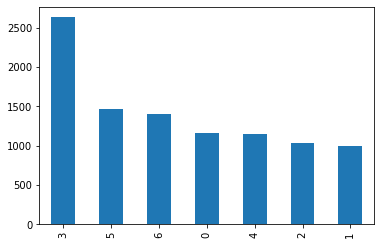

In [ ]:
trainY.value_counts().plot(kind = 'bar')
print(trainY.size)

In [ ]:
testY.value_counts().plot(kind = 'bar')

In [ ]:
# 문장 추출
sentences = trainX['input'].values
sentences[:10]

array(['부동산 투자 이렇다 쉽다 추천 평생 부동산 투자 위하다 지침서 프롤로그 단계 부동산 투자 위하다 기초 다지다 가격 상승 부동산 찾다 부동산 가격 오르다 내리다 원리 가격 오르다 부동산 찾다 위하다 기억 가지 흐름 최대한 싸다 사다 방법 매물 투자 정확 시세 파악 먼저 시세 파악 비교 여러 가지 방법 인터넷 올라오다 허위 매물 골라내다 방법 성공 아파트 투자 위하다 기본 상식 갖추다 아파트 아파텔 면적 제대로 알다 단지 시세 차이 크다 아파트 찾다 대형 중형 소형 가치 정하다 지다 있다 않다 칼럼 시세 차익 투자 필요 단계 부동산 투자 쉽다 시작 공인 중개 관계 투자 수익 결정 원하다 매물 주다 중개 업소 찾다 일반 매물 매물 만들다 방법 효력 있다 계약서 꼼꼼 작성 요령 계약금 중도금 입금 중요 시세 차익 크다 아파트 찾다 방법 도장 찍다 순간 돌이키다 없다 현장 학군 파악 되다 아파트 찾다 파악 되다 아파트 찾다 칼럼 싸다 평가 의미 이해 평가 부동산 투자 방법 매매 대비 전세 비율 평가 부동산 찾다 매물 기준 평가 부동산 찾다 지역 변화 기준 평가 부동산 찾다 스스로 평가 들다 경매 새롭다 평가 지역 찾다 생각 확장 칼럼 똑같다 가격 상승 싸다 불황 비싸다 단계 이상 수익 거두다 부동산 찾다 신도시 적절 투자 시기 평가 부동산 찾다 방법 신도시 사례 부천 중동 도시 시세 변화 지역 뉴스 검색 주변 변화 가능 높다 찾다 퍼즐 맞추다 통하다 기존 정보 더욱 구체 대중 눈앞 호재 보다 판단 다음 움직임 생각 크다 수익 얻다 있다 분양 아파트 투자 방법 원흥 지구 사례 사람 관심 갖다 않다 분양 아파트 보석 되다 분양 아파트 골라내다 분양 아파트 보석 되다 과정 분양 아파트 투자 추가 알다 사항 칼럼 언론 반대 하다 성공 단계 상승 하락 수익 거두다 시장 사이클 부동산 투자 타이밍 부동산 시장 단계 사이클 시장 흐름 따르다 투자 방법 다르다 지금 부동산 시장 시기 정부 정책 부동산 투자 타이밍 고수 정부 입장 이해 활용 고수 정책 따르다 수급 변화 

In [ ]:
train_dataset = pd.DataFrame({'sentence': sentences, 'label': trainY}, columns=['sentence', 'label'])

In [ ]:
# 문장 추출
sentences = testX['input'].values
sentences[:10]

array(['사부 작다 사부 작다 에뚜알 핸드 메이드 매일 기록 일기 숙제 다이어리 종류 다이어리 꾸미다 스타일 다이어리 고르다 방법 오늘 특별 다이어리 꾸미다 레이아웃 다이어리 꾸미다 색감 맞추다 테마 맞추다 다이어리 꾸미다 색다르다 다이어리 꾸미다 보너스 페이지 에뚜알 세삐 공방 에피소드 마음 표현 부모 사랑해요 테마 부모 그림 그리다 테마 용돈 봉투 만들다 테마 효도 복권 쿠폰 만들다 우정 영원히 테마 커플 만들다 테마 미니 생일 카드 만들다 테마 수첩 표지 꾸미다 보너스 페이지 에뚜알 작업 테이블 소개 특별 인싸 되다 있다 그거 사다 케이스 꾸미다 손거울 꾸미다 필통 꾸미다 책갈피 만들다 보너스 페이지 에뚜알 배우다 하다 있다 문구 제품 만들다 있다 메모지 만들다 그림 스티커 만들다 사진 스티커 만들다 다꾸러 구매 꾸다 인스타그램 유튜브',
       '디바인 매트릭스 서문 디바인 매트릭스 발견 우주 만물 잇다 있다 신비 질문 비다 공간 사이사이 있다 대답 디바인 매트릭스 패러다임 깨부수다 상식 뒤엎다 실험 상상 현실 잇다 다리 디바인 매트릭스 어떻다 작동 수동 관찰자 강력 창조자 한번 연결 영원히 연결 홀로 그램 우주 살아가다 거기 지금 매트릭스 시공간 뛰어넘다 디바인 매트릭스 보내다 메시지 양자 의식 살다 사랑 치유 우주 대화 매트릭스 보내다 메시지 관계 거울 읽기 자신 보내다 메시지 현실 코드 다시 쓰다 창조 비결 가지 주석 찾아보다',
       '러스트 작법 입문 프리랜서 일러스트레이 입문 게임 시장 게임 게임 일러스트레이터 게임 산업 현재 게임 게임 일러스트레이 그림 입문 그림 그리다 이유 그리다 생각 방법 적성 재능 노력 그림 개성 스타일 추천 입문 공부 표절 트레이싱 태블릿 그림체 기본 용어 프리랜서 일러스트레이 프리랜서 일러스트레이 러스트 공정 과정 포토샵 알아보다 포토샵 어도비 계정 생성 포토샵 다운로드 설치 포토샵 화면 구성 알아보다 포토샵 환경 설정 메인 메뉴 알아보다 캔버스 생성 박스 알아보다 레이어 생성 레이어 속성 알아보

In [ ]:
test_dataset = pd.DataFrame({'sentence': sentences, 'label': testY}, columns=['sentence', 'label'])

In [ ]:
dataset_train = train_dataset.values
dataset_test = test_dataset.values

In [ ]:
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = []
        self.labels = []
        
        for i in dataset:
            try:
                self.sentences.append(transform([i[sent_idx]]))
                self.labels.append(np.int32(i[label_idx]))
            except Exception as e:
                print(e)
                print(len(self.sentences), len(self.labels))

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
## Setting parameters
max_len = 128 #128
batch_size = 2 #cuda out of memory ...
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  2e-5

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# NUM_LABELS = max(set(df['label'])) + 1
# NUM_LABELS
NUM_LABELS = max(set(tdf['n2'])) +1
NUM_LABELS

7

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768, #768 #뭐여 이게.....뭔 조화여 dim이 달라지구로
                 #https://www.google.com/search?sxsrf=ALeKk01zaV-xIa8Z0CUMGLodIa4vl6Z9fg%3A1616147579994&lei=e3RUYIKtPMizmAXPr7D4BA&q=Mat1%20dim%201%20must%20match%20mat2%20dim%200&ved=2ahUKEwjC1qPzirzvAhXIGaYKHc8XDE8QsKwBKAB6BAgUEAE&biw=832&bih=720
                 num_classes=NUM_LABELS,     #9,#num_labels
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
# 역시 문제가 중간에 라벨 빠진 것 때문이었군

In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.25).to(device)

In [ ]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [ ]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

In [ ]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
from time import gmtime, strftime
START_TIME = strftime("%Y_%m_%d_%H_%M_%S", gmtime())

SAVE_PATH = BASE_PATH+"/bert_model_{}.pth".format(START_TIME)

In [ ]:
token_ids

tensor([[   2, 2431, 4768, 3647, 6049, 5782,  517, 6657, 5782, 4559, 4847, 2431,
         4768, 3552, 7798, 4297, 7491, 6553,  517, 7753, 6085, 6079, 5538, 1586,
         2431, 4768, 3552, 7798, 1304, 1562, 7318, 5782,  728, 2670, 2431,  517,
         7404, 5782, 2431,  728, 3425, 5782, 1444, 5782, 3533, 6122,  728, 3425,
         5782, 2431,  517, 7404, 5782, 3552, 7798, 1291,  767, 5197, 4529, 3076,
         5782, 2573, 5782, 2270, 1986, 6241, 4768, 4092, 7944, 2959, 6579, 4802,
         2012, 2959, 6579, 4802, 2518, 3304,  767, 2270, 3794, 3440, 6964, 5782,
         5041, 1986, 6241, 1016, 6003, 5678, 5782, 2270, 2783, 3131, 4768, 3552,
         7798, 1280, 2658, 6730,  827, 5782, 3131, 3093, 7682, 7622, 2029, 7202,
         4136, 3166, 5782, 1593, 2959, 6579, 4413, 4684, 3131,  517, 7404, 5782,
         1690, 4257, 7921, 2853,  771, 4092, 7798,    3],
        [   2, 1169, 3285, 1559, 3285, 3285, 4932, 3862, 1559, 1973, 5782, 2135,
         7436, 3453, 5782, 5141, 2056, 2187, 5782, 

In [ ]:
len(token_ids[0])

128

In [ ]:
segment_ids

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')

In [ ]:
len(segment_ids[0])

128

In [ ]:
label

tensor([3, 5], device='cuda:0')

In [ ]:
valid_length

tensor([128, 128], dtype=torch.int32)

In [ ]:
model(token_ids, valid_length, segment_ids)

tensor([[-0.4095,  0.0527,  0.2204,  0.2780, -0.0335,  0.6422,  0.7068],
        [-0.4317, -0.2753,  0.1466,  0.1255,  0.3554,  0.3593,  0.7229]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.753183126449585 train acc 0.0
epoch 1 batch id 201 loss 2.2546920776367188 train acc 0.15920398009950248
epoch 1 batch id 401 loss 1.739863634109497 train acc 0.2057356608478803
epoch 1 batch id 601 loss 2.2685775756835938 train acc 0.24292845257903495
epoch 1 batch id 801 loss 2.0413599014282227 train acc 0.28651685393258425
epoch 1 batch id 1001 loss 1.4675297737121582 train acc 0.32667332667332666
epoch 1 batch id 1201 loss 1.7040374279022217 train acc 0.3726061615320566
epoch 1 batch id 1401 loss 1.4535787105560303 train acc 0.4097073518915061
epoch 1 batch id 1601 loss 3.1003990173339844 train acc 0.4391005621486571
epoch 1 batch id 1801 loss 0.28711453080177307 train acc 0.4655746807329261
epoch 1 batch id 2001 loss 1.6680306196212769 train acc 0.49025487256371814
epoch 1 batch id 2201 loss 0.4799499809741974 train acc 0.5106769650159019
epoch 1 batch id 2401 loss 1.479156732559204 train acc 0.5301957517700958
epoch 1 batch id 2601 loss 0.055861026048660


epoch 1 test acc 0.7264227642276423


epoch 2 batch id 1 loss 0.05107031390070915 train acc 1.0
epoch 2 batch id 201 loss 0.019005727022886276 train acc 0.7238805970149254
epoch 2 batch id 401 loss 0.22234971821308136 train acc 0.7044887780548629
epoch 2 batch id 601 loss 2.2535884380340576 train acc 0.7179700499168054
epoch 2 batch id 801 loss 3.4066009521484375 train acc 0.7322097378277154
epoch 2 batch id 1001 loss 1.1474289894104004 train acc 0.7312687312687313
epoch 2 batch id 1201 loss 0.6625626683235168 train acc 0.7289758534554538
epoch 2 batch id 1401 loss 1.6288220882415771 train acc 0.7326909350463955
epoch 2 batch id 1601 loss 4.751420974731445 train acc 0.7323547782635853
epoch 2 batch id 1801 loss 0.04485831409692764 train acc 0.7340366463076069
epoch 2 batch id 2001 loss 0.76629239320755 train acc 0.7338830584707646
epoch 2 batch id 2201 loss 0.05977698415517807 train acc 0.7380736029077692
epoch 2 batch id 2401 loss 0.03270848095417023 train acc 0.7409412744689713
epoch 2 batch id 2601 loss 1.50551211833953


epoch 2 test acc 0.7467479674796748


epoch 3 batch id 1 loss 0.012113604694604874 train acc 1.0
epoch 3 batch id 201 loss 0.011402886360883713 train acc 0.7860696517412935
epoch 3 batch id 401 loss 0.011132331565022469 train acc 0.7755610972568578
epoch 3 batch id 601 loss 2.1531338691711426 train acc 0.7920133111480865
epoch 3 batch id 801 loss 0.08502213656902313 train acc 0.8046192259675405
epoch 3 batch id 1001 loss 0.00887947529554367 train acc 0.8056943056943057
epoch 3 batch id 1201 loss 0.0031417026184499264 train acc 0.8005828476269775
epoch 3 batch id 1401 loss 0.05277583375573158 train acc 0.7980014275517487
epoch 3 batch id 1601 loss 1.5785809755325317 train acc 0.7963772642098689
epoch 3 batch id 1801 loss 0.0036803532857447863 train acc 0.7976124375347029
epoch 3 batch id 2001 loss 0.06125173345208168 train acc 0.7983508245877061
epoch 3 batch id 2201 loss 0.04116830602288246 train acc 0.7998636983189459
epoch 3 batch id 2401 loss 0.02134816348552704 train acc 0.802582257392753
epoch 3 batch id 2601 loss 0.0


epoch 3 test acc 0.7459349593495935


epoch 4 batch id 1 loss 0.004714843817055225 train acc 1.0
epoch 4 batch id 201 loss 0.007767336443066597 train acc 0.8333333333333334
epoch 4 batch id 401 loss 0.0069619277492165565 train acc 0.8403990024937655
epoch 4 batch id 601 loss 2.5008466243743896 train acc 0.8527454242928453
epoch 4 batch id 801 loss 2.6348767280578613 train acc 0.8614232209737828
epoch 4 batch id 1001 loss 0.0037079472094774246 train acc 0.8591408591408591
epoch 4 batch id 1201 loss 0.003803583327680826 train acc 0.855120732722731
epoch 4 batch id 1401 loss 0.006289445795118809 train acc 0.8508208422555318
epoch 4 batch id 1601 loss 1.3347108364105225 train acc 0.8516552154903185
epoch 4 batch id 1801 loss 0.0032583356369286776 train acc 0.8525818989450306
epoch 4 batch id 2001 loss 0.008669262751936913 train acc 0.8538230884557722
epoch 4 batch id 2201 loss 0.013729073107242584 train acc 0.8546115402089959
epoch 4 batch id 2401 loss 0.006393606774508953 train acc 0.8548521449396085
epoch 4 batch id 2601 los


epoch 4 test acc 0.7422764227642277


epoch 5 batch id 1 loss 0.0017520326655358076 train acc 1.0
epoch 5 batch id 201 loss 0.006450633518397808 train acc 0.8781094527363185
epoch 5 batch id 401 loss 0.004061375744640827 train acc 0.8740648379052369
epoch 5 batch id 601 loss 2.1384224891662598 train acc 0.8843594009983361
epoch 5 batch id 801 loss 0.006487207021564245 train acc 0.8895131086142322
epoch 5 batch id 1001 loss 0.003465876914560795 train acc 0.8861138861138861
epoch 5 batch id 1201 loss 0.3107554316520691 train acc 0.8846794338051623
epoch 5 batch id 1401 loss 0.006952923256903887 train acc 0.8832976445396146
epoch 5 batch id 1601 loss 0.009943410754203796 train acc 0.8835103060587133
epoch 5 batch id 1801 loss 0.0050043510273098946 train acc 0.8847862298722932
epoch 5 batch id 2001 loss 0.0040041483007371426 train acc 0.8865567216391804
epoch 5 batch id 2201 loss 0.008945323526859283 train acc 0.886869604725125
epoch 5 batch id 2401 loss 0.007434850558638573 train acc 0.8890045814244065
epoch 5 batch id 2601 l


epoch 5 test acc 0.7666666666666667


epoch 6 batch id 1 loss 0.0015784540446475148 train acc 1.0
epoch 6 batch id 201 loss 0.004541956819593906 train acc 0.9154228855721394
epoch 6 batch id 401 loss 0.0021413112990558147 train acc 0.9052369077306733
epoch 6 batch id 601 loss 2.3138668537139893 train acc 0.9034941763727121
epoch 6 batch id 801 loss 0.004744754638522863 train acc 0.9076154806491885
epoch 6 batch id 1001 loss 0.001961399568244815 train acc 0.9035964035964036
epoch 6 batch id 1201 loss 0.0009266235865652561 train acc 0.9029975020815987
epoch 6 batch id 1401 loss 0.004811848979443312 train acc 0.9025695931477516
epoch 6 batch id 1601 loss 0.0028135941829532385 train acc 0.9034978138663335
epoch 6 batch id 1801 loss 0.006299392320215702 train acc 0.9050527484730705
epoch 6 batch id 2001 loss 0.0014400363434106112 train acc 0.9067966016991504
epoch 6 batch id 2201 loss 0.006104608066380024 train acc 0.9084507042253521
epoch 6 batch id 2401 loss 0.0031050138641148806 train acc 0.9104539775093711
epoch 6 batch id 


epoch 6 test acc 0.7520325203252033


epoch 7 batch id 1 loss 0.0022696375381201506 train acc 1.0
epoch 7 batch id 201 loss 0.004022584296762943 train acc 0.9378109452736318
epoch 7 batch id 401 loss 0.0010719629935920238 train acc 0.9351620947630923
epoch 7 batch id 601 loss 2.129101037979126 train acc 0.937603993344426
epoch 7 batch id 801 loss 0.0033855584915727377 train acc 0.9431960049937578
epoch 7 batch id 1001 loss 0.0012888284400105476 train acc 0.9395604395604396
epoch 7 batch id 1201 loss 0.0006552485865540802 train acc 0.9392173189009159
epoch 7 batch id 1401 loss 0.002965653082355857 train acc 0.9389721627408993
epoch 7 batch id 1601 loss 0.002712076064199209 train acc 0.9391005621486571
epoch 7 batch id 1801 loss 0.002186897909268737 train acc 0.939200444197668
epoch 7 batch id 2001 loss 0.002104271901771426 train acc 0.9380309845077461
epoch 7 batch id 2201 loss 0.0039630429819226265 train acc 0.9384370740572467
epoch 7 batch id 2401 loss 0.002273187506943941 train acc 0.9387755102040817
epoch 7 batch id 260


epoch 7 test acc 0.7577235772357723


epoch 8 batch id 1 loss 0.000809004413895309 train acc 1.0
epoch 8 batch id 201 loss 0.0016595503548160195 train acc 0.9527363184079602
epoch 8 batch id 401 loss 0.0012679267674684525 train acc 0.9488778054862843
epoch 8 batch id 601 loss 2.5355098247528076 train acc 0.9509151414309485
epoch 8 batch id 801 loss 0.0019569764845073223 train acc 0.9569288389513109
epoch 8 batch id 1001 loss 0.0010440044570714235 train acc 0.9545454545454546
epoch 8 batch id 1201 loss 0.0005417037173174322 train acc 0.9558701082431307
epoch 8 batch id 1401 loss 0.0015587547095492482 train acc 0.9553890078515346
epoch 8 batch id 1601 loss 0.0022858704905956984 train acc 0.9553404122423486
epoch 8 batch id 1801 loss 0.00190707016736269 train acc 0.9569683509161577
epoch 8 batch id 2001 loss 0.0015353963244706392 train acc 0.956271864067966
epoch 8 batch id 2201 loss 0.0019699176773428917 train acc 0.9568378009995456
epoch 8 batch id 2401 loss 0.0018106503412127495 train acc 0.9579341940857976
epoch 8 batch i


epoch 8 test acc 0.7565040650406504


epoch 9 batch id 1 loss 0.0006676999619230628 train acc 1.0
epoch 9 batch id 201 loss 0.0014400521758943796 train acc 0.9751243781094527
epoch 9 batch id 401 loss 0.0007044796366244555 train acc 0.9675810473815462
epoch 9 batch id 601 loss 0.0014341685455292463 train acc 0.9725457570715474
epoch 9 batch id 801 loss 0.0012393369106575847 train acc 0.9750312109862672
epoch 9 batch id 1001 loss 0.0005373053136281669 train acc 0.972027972027972
epoch 9 batch id 1201 loss 0.0005860748351551592 train acc 0.9708576186511241
epoch 9 batch id 1401 loss 0.0010876775486394763 train acc 0.9685938615274804
epoch 9 batch id 1601 loss 0.0007526776753365993 train acc 0.9684572142410993
epoch 9 batch id 1801 loss 0.0008688619127497077 train acc 0.968906163242643
epoch 9 batch id 2001 loss 0.0009702862007543445 train acc 0.9692653673163418
epoch 9 batch id 2201 loss 0.0020056157372891903 train acc 0.9686506133575647
epoch 9 batch id 2401 loss 0.0009808941977098584 train acc 0.9695960016659725
epoch 9 ba


epoch 9 test acc 0.75


epoch 10 batch id 1 loss 0.0004984088591299951 train acc 1.0
epoch 10 batch id 201 loss 0.0006300408858805895 train acc 0.9850746268656716
epoch 10 batch id 401 loss 0.0005569694330915809 train acc 0.9800498753117207
epoch 10 batch id 601 loss 0.0005499391700141132 train acc 0.9800332778702163
epoch 10 batch id 801 loss 0.0012909057550132275 train acc 0.980649188514357
epoch 10 batch id 1001 loss 0.00047260147402994335 train acc 0.9790209790209791
epoch 10 batch id 1201 loss 0.0003952566476073116 train acc 0.9783513738551207
epoch 10 batch id 1401 loss 0.0010400231694802642 train acc 0.9775160599571735
epoch 10 batch id 1601 loss 0.0008646000060252845 train acc 0.9772017489069331
epoch 10 batch id 1801 loss 0.0009780225809663534 train acc 0.9775124930594115
epoch 10 batch id 2001 loss 0.0007435092702507973 train acc 0.9772613693153424
epoch 10 batch id 2201 loss 0.0013004805659875274 train acc 0.9763743752839619
epoch 10 batch id 2401 loss 0.0010677382815629244 train acc 0.976468138275


epoch 10 test acc 0.7508130081300813


In [ ]:
torch.cuda.empty_cache()

In [ ]:
## Setting parameters
max_len = 128 #128
batch_size = 2 #cuda out of memory ...
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  2e-5

In [ ]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.202669620513916 train acc 0.0
epoch 1 batch id 201 loss 1.51768159866333 train acc 0.26119402985074625
epoch 1 batch id 401 loss 0.9415091276168823 train acc 0.45261845386533667
epoch 1 batch id 601 loss 0.8676822781562805 train acc 0.5948419301164726
epoch 1 batch id 801 loss 0.4146400988101959 train acc 0.6903870162297129
epoch 1 batch id 1001 loss 0.1491875797510147 train acc 0.7447552447552448
epoch 1 batch id 1201 loss 0.05276612192392349 train acc 0.7826810990840966
epoch 1 batch id 1401 loss 0.029117070138454437 train acc 0.806566738044254
epoch 1 batch id 1601 loss 0.015162722207605839 train acc 0.8260462211118051
epoch 1 batch id 1801 loss 0.01166332233697176 train acc 0.8414769572459745
epoch 1 batch id 2001 loss 0.006706171669065952 train acc 0.8530734632683659
epoch 1 batch id 2201 loss 0.011110260151326656 train acc 0.8616537937301226
epoch 1 batch id 2401 loss 0.00467660604044795 train acc 0.8696376509787589
epoch 1 batch id 2601 loss 0.004005441


epoch 1 test acc 0.7459349593495935


epoch 2 batch id 1 loss 0.0009805477457121015 train acc 1.0
epoch 2 batch id 201 loss 0.9333748817443848 train acc 0.9328358208955224
epoch 2 batch id 401 loss 0.0018568094819784164 train acc 0.9214463840399002
epoch 2 batch id 601 loss 1.91031813621521 train acc 0.9267886855241264
epoch 2 batch id 801 loss 0.001329654362052679 train acc 0.9325842696629213
epoch 2 batch id 1001 loss 0.0018080155132338405 train acc 0.9335664335664335
epoch 2 batch id 1201 loss 0.0007841134211048484 train acc 0.9342214820982515
epoch 2 batch id 1401 loss 0.0015222758520394564 train acc 0.9318344039971449
epoch 2 batch id 1601 loss 0.0020065419375896454 train acc 0.9291068082448469
epoch 2 batch id 1801 loss 0.001999464351683855 train acc 0.9325374791782343
epoch 2 batch id 2001 loss 0.0013112120795994997 train acc 0.9337831084457772
epoch 2 batch id 2201 loss 0.004152308218181133 train acc 0.935029532030895
epoch 2 batch id 2401 loss 0.0014656693674623966 train acc 0.9350270720533111
epoch 2 batch id 260


epoch 2 test acc 0.760569105691057


epoch 3 batch id 1 loss 0.0007136226631700993 train acc 1.0
epoch 3 batch id 201 loss 0.0011869934387505054 train acc 0.9427860696517413
epoch 3 batch id 401 loss 0.0008109890623018146 train acc 0.9314214463840399
epoch 3 batch id 601 loss 1.9863708019256592 train acc 0.9342762063227953
epoch 3 batch id 801 loss 0.0017426380654796958 train acc 0.9413233458177278
epoch 3 batch id 1001 loss 0.0015431722858920693 train acc 0.9430569430569431
epoch 3 batch id 1201 loss 0.0008210139349102974 train acc 0.9450457951706911
epoch 3 batch id 1401 loss 0.0008386806002818048 train acc 0.9450392576730906
epoch 3 batch id 1601 loss 0.0012042985763400793 train acc 0.9462835727670206
epoch 3 batch id 1801 loss 0.00103034230414778 train acc 0.9475291504719601
epoch 3 batch id 2001 loss 0.0006459053256548941 train acc 0.9482758620689655
epoch 3 batch id 2201 loss 0.0017074659699574113 train acc 0.9479781917310314
epoch 3 batch id 2401 loss 0.0009677493944764137 train acc 0.9473136193252811
epoch 3 batch


epoch 3 test acc 0.7491869918699187


epoch 4 batch id 1 loss 0.000528477132320404 train acc 1.0
epoch 4 batch id 201 loss 0.0007784710032865405 train acc 0.972636815920398
epoch 4 batch id 401 loss 0.0008959538536146283 train acc 0.9688279301745636
epoch 4 batch id 601 loss 0.00038842749199829996 train acc 0.9708818635607321
epoch 4 batch id 801 loss 0.000937609700486064 train acc 0.9731585518102372
epoch 4 batch id 1001 loss 0.0005406432319432497 train acc 0.9735264735264735
epoch 4 batch id 1201 loss 0.00046494934940710664 train acc 0.9725228975853455
epoch 4 batch id 1401 loss 0.000869462382979691 train acc 0.9718058529621699
epoch 4 batch id 1601 loss 0.000785098469350487 train acc 0.9709556527170519
epoch 4 batch id 1801 loss 0.001176197431050241 train acc 0.9722376457523598
epoch 4 batch id 2001 loss 0.0005323661025613546 train acc 0.9725137431284357
epoch 4 batch id 2201 loss 0.001486969063989818 train acc 0.9725124943207633
epoch 4 batch id 2401 loss 0.0005663785268552601 train acc 0.9723032069970845
epoch 4 batch


epoch 4 test acc 0.751219512195122


epoch 5 batch id 1 loss 0.0005155818653292954 train acc 1.0
epoch 5 batch id 201 loss 0.0003465333138592541 train acc 0.9875621890547264
epoch 5 batch id 401 loss 0.0005349371349439025 train acc 0.9812967581047382
epoch 5 batch id 601 loss 0.0009093130938708782 train acc 0.9833610648918469
epoch 5 batch id 801 loss 0.0009035988477990031 train acc 0.9850187265917603
epoch 5 batch id 1001 loss 0.0006514432025142014 train acc 0.9845154845154845
epoch 5 batch id 1201 loss 0.0003376513777766377 train acc 0.9837635303913406
epoch 5 batch id 1401 loss 0.001129048177972436 train acc 0.9842969307637401
epoch 5 batch id 1601 loss 0.0005560159333981574 train acc 0.9831355402873204
epoch 5 batch id 1801 loss 0.0006315186619758606 train acc 0.9836202109938923
epoch 5 batch id 2001 loss 0.0006184313679113984 train acc 0.9835082458770614
epoch 5 batch id 2201 loss 0.001139734173193574 train acc 0.9829622898682417
epoch 5 batch id 2401 loss 0.0006954893469810486 train acc 0.9827155351936693
epoch 5 ba


epoch 5 test acc 0.7613821138211382


In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.25).to(device)
num_epochs = 3

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.264289379119873 train acc 0.0
epoch 1 batch id 201 loss 1.9369313716888428 train acc 0.022388059701492536
epoch 1 batch id 401 loss 1.957840919494629 train acc 0.026184538653366583
epoch 1 batch id 601 loss 2.127451181411743 train acc 0.029118136439267885
epoch 1 batch id 801 loss 2.221571683883667 train acc 0.031835205992509365
epoch 1 batch id 1001 loss 2.1295440196990967 train acc 0.03396603396603397
epoch 1 batch id 1201 loss 2.1188559532165527 train acc 0.036219816819317234
epoch 1 batch id 1401 loss 1.973559856414795 train acc 0.03890078515346181
epoch 1 batch id 1601 loss 2.0069990158081055 train acc 0.04871955028107433
epoch 1 batch id 1801 loss 1.7855254411697388 train acc 0.06052193225985564
epoch 1 batch id 2001 loss 1.6364669799804688 train acc 0.07721139430284858
epoch 1 batch id 2201 loss 1.8174152374267578 train acc 0.10063607451158564
epoch 1 batch id 2401 loss 1.632214903831482 train acc 0.13598500624739693
epoch 1 batch id 2601 loss 1.2284334


epoch 1 test acc 0.7666666666666667


epoch 2 batch id 1 loss 0.12163103371858597 train acc 1.0
epoch 2 batch id 201 loss 0.09784342348575592 train acc 0.9850746268656716
epoch 2 batch id 401 loss 0.06331868469715118 train acc 0.9788029925187033
epoch 2 batch id 601 loss 0.09420203417539597 train acc 0.9833610648918469
epoch 2 batch id 801 loss 0.06711828708648682 train acc 0.9850187265917603
epoch 2 batch id 1001 loss 0.03915178030729294 train acc 0.985014985014985
epoch 2 batch id 1201 loss 0.044276751577854156 train acc 0.9845961698584513
epoch 2 batch id 1401 loss 0.041644901037216187 train acc 0.9846538187009279
epoch 2 batch id 1601 loss 0.03743314743041992 train acc 0.9828232354778264
epoch 2 batch id 1801 loss 0.027055490761995316 train acc 0.9838978345363687
epoch 2 batch id 2001 loss 0.019703075289726257 train acc 0.9837581209395302
epoch 2 batch id 2201 loss 0.0171453095972538 train acc 0.9831894593366651
epoch 2 batch id 2401 loss 0.014669624157249928 train acc 0.9825072886297376
epoch 2 batch id 2601 loss 0.00


epoch 2 test acc 0.7617886178861789


epoch 3 batch id 1 loss 0.0014270150568336248 train acc 1.0
epoch 3 batch id 201 loss 0.0019821375608444214 train acc 0.9875621890547264
epoch 3 batch id 401 loss 0.0016622492112219334 train acc 0.9800498753117207
epoch 3 batch id 601 loss 0.0021255607716739178 train acc 0.9816971713810316
epoch 3 batch id 801 loss 0.002495769876986742 train acc 0.9831460674157303
epoch 3 batch id 1001 loss 0.0016864822246134281 train acc 0.9825174825174825
epoch 3 batch id 1201 loss 0.0022916533052921295 train acc 0.9825145711906744
epoch 3 batch id 1401 loss 0.0012381370179355145 train acc 0.9825124910778016
epoch 3 batch id 1601 loss 0.0014240035088732839 train acc 0.9803247970018738
epoch 3 batch id 1801 loss 0.0012929948279634118 train acc 0.9800111049416991
epoch 3 batch id 2001 loss 0.0014606127515435219 train acc 0.9795102448775612
epoch 3 batch id 2201 loss 0.0023105612490326166 train acc 0.9788732394366197
epoch 3 batch id 2401 loss 0.0017207958735525608 train acc 0.9783423573511038
epoch 3 b


epoch 3 test acc 0.7410569105691057


In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.25).to(device)
num_epochs = 2

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 2.123784065246582 train acc 0.0
epoch 1 batch id 201 loss 0.023343220353126526 train acc 0.9054726368159204
epoch 1 batch id 401 loss 0.006389590911567211 train acc 0.940149625935162
epoch 1 batch id 601 loss 0.007650736253708601 train acc 0.9492512479201332
epoch 1 batch id 801 loss 0.012980122119188309 train acc 0.9569288389513109
epoch 1 batch id 1001 loss 0.004353701137006283 train acc 0.958041958041958
epoch 1 batch id 1201 loss 0.0042832717299461365 train acc 0.9579517069109076
epoch 1 batch id 1401 loss 3.6662161350250244 train acc 0.9603854389721628
epoch 1 batch id 1601 loss 0.003791389986872673 train acc 0.9603372891942535
epoch 1 batch id 1801 loss 0.002576895523816347 train acc 0.9614103275957802
epoch 1 batch id 2001 loss 0.003793111303821206 train acc 0.9607696151924038
epoch 1 batch id 2201 loss 0.0037249838933348656 train acc 0.9606996819627442
epoch 1 batch id 2401 loss 0.0036166012287139893 train acc 0.9591836734693877
epoch 1 batch id 2601 los


epoch 1 test acc 0.7483739837398374


epoch 2 batch id 1 loss 0.0012696043122559786 train acc 1.0
epoch 2 batch id 201 loss 0.002106241649016738 train acc 0.945273631840796
epoch 2 batch id 401 loss 0.0021197055466473103 train acc 0.9538653366583542
epoch 2 batch id 601 loss 0.0012780705001205206 train acc 0.9608985024958403
epoch 2 batch id 801 loss 0.0011264861095696688 train acc 0.9650436953807741
epoch 2 batch id 1001 loss 0.0015553984558209777 train acc 0.9665334665334665
epoch 2 batch id 1201 loss 0.0008141510188579559 train acc 0.9658617818484596
epoch 2 batch id 1401 loss 0.00101185473613441 train acc 0.9635974304068522
epoch 2 batch id 1601 loss 0.0011296272277832031 train acc 0.9606495940037476
epoch 2 batch id 1801 loss 0.0015522170579060912 train acc 0.960577456968351
epoch 2 batch id 2001 loss 0.001956468913704157 train acc 0.9587706146926537
epoch 2 batch id 2201 loss 0.0038055148907005787 train acc 0.955474784189005
epoch 2 batch id 2401 loss 0.0012126361252740026 train acc 0.9543940024989588
epoch 2 batch i


epoch 2 test acc 0.7524390243902439


In [ ]:
model = BERTClassifier(bertmodel,  dr_rate=0.25).to(device)
num_epochs = 20

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    torch.save(model.state_dict(), SAVE_PATH)
    print("Model saved at {}".format(SAVE_PATH))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(notebook.tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.4703929424285889 train acc 0.5
epoch 1 batch id 201 loss 0.015069005079567432 train acc 0.900497512437811
epoch 1 batch id 401 loss 0.005532930605113506 train acc 0.9301745635910225
epoch 1 batch id 601 loss 0.008669550530612469 train acc 0.9384359400998337
epoch 1 batch id 801 loss 0.006167402490973473 train acc 0.9425717852684145
epoch 1 batch id 1001 loss 0.0031011556275188923 train acc 0.9460539460539461
epoch 1 batch id 1201 loss 0.002772663254290819 train acc 0.9475437135720233
epoch 1 batch id 1401 loss 0.003794932272285223 train acc 0.9489650249821556
epoch 1 batch id 1601 loss 3.4756393432617188 train acc 0.9487820112429731
epoch 1 batch id 1801 loss 0.002166273072361946 train acc 0.9478067740144365
epoch 1 batch id 2001 loss 0.00301573658362031 train acc 0.947776111944028
epoch 1 batch id 2201 loss 0.002481092233210802 train acc 0.9486597001363016
epoch 1 batch id 2401 loss 0.0020591903012245893 train acc 0.9496043315285297
epoch 1 batch id 2601 loss


epoch 1 test acc 0.748780487804878


epoch 2 batch id 1 loss 0.0017986905295401812 train acc 1.0
epoch 2 batch id 201 loss 0.0009073968976736069 train acc 0.9751243781094527
epoch 2 batch id 401 loss 0.0011093728244304657 train acc 0.9625935162094763
epoch 2 batch id 601 loss 0.0013790726661682129 train acc 0.9700499168053245
epoch 2 batch id 801 loss 0.0011142190778627992 train acc 0.9694132334581773
epoch 2 batch id 1001 loss 0.001110114622861147 train acc 0.971028971028971
epoch 2 batch id 1201 loss 0.0008965262677520514 train acc 0.9712739383846795
epoch 2 batch id 1401 loss 0.0012091236421838403 train acc 0.9707351891506067
epoch 2 batch id 1601 loss 0.002635026816278696 train acc 0.9700187382885697
epoch 2 batch id 1801 loss 0.0011669278610497713 train acc 0.9705719044975014
epoch 2 batch id 2001 loss 0.0010153533658012748 train acc 0.9687656171914043
epoch 2 batch id 2201 loss 0.0021562366746366024 train acc 0.9684234438891413
epoch 2 batch id 2401 loss 0.0006522524636238813 train acc 0.9681382757184507
epoch 2 bat


epoch 2 test acc 0.7556910569105691


epoch 3 batch id 1 loss 0.0004017566971015185 train acc 1.0
epoch 3 batch id 201 loss 0.00040623347740620375 train acc 0.9825870646766169
epoch 3 batch id 401 loss 0.00040813334635458887 train acc 0.983790523690773
epoch 3 batch id 601 loss 0.0004286978510208428 train acc 0.9875207986688852
epoch 3 batch id 801 loss 0.000847638410050422 train acc 0.9868913857677902
epoch 3 batch id 1001 loss 0.0005662359180860221 train acc 0.987012987012987
epoch 3 batch id 1201 loss 0.0006582686328329146 train acc 0.985428809325562
epoch 3 batch id 1401 loss 0.0005868737935088575 train acc 0.9853675945753033
epoch 3 batch id 1601 loss 2.784695625305176 train acc 0.9834478450968145
epoch 3 batch id 1801 loss 0.0007594323251396418 train acc 0.9833425874514159
epoch 3 batch id 2001 loss 0.0005300951306708157 train acc 0.9835082458770614
epoch 3 batch id 2201 loss 0.0010778757277876139 train acc 0.9829622898682417
epoch 3 batch id 2401 loss 0.000492626044433564 train acc 0.9831320283215327
epoch 3 batch i


epoch 3 test acc 0.760569105691057


epoch 4 batch id 1 loss 0.00039925368037074804 train acc 1.0
epoch 4 batch id 201 loss 0.000433213310316205 train acc 0.9875621890547264
epoch 4 batch id 401 loss 0.000598556362092495 train acc 0.9850374064837906
epoch 4 batch id 601 loss 0.0005240244208835065 train acc 0.9883527454242929
epoch 4 batch id 801 loss 0.0005951539496891201 train acc 0.9875156054931336
epoch 4 batch id 1001 loss 0.0007782235625199974 train acc 0.988011988011988
epoch 4 batch id 1201 loss 0.0003959302557632327 train acc 0.9875104079933389
epoch 4 batch id 1401 loss 0.0006360049010254443 train acc 0.9875089221984297
epoch 4 batch id 1601 loss 0.00034618331119418144 train acc 0.9865708931917552
epoch 4 batch id 1801 loss 0.0005602457094937563 train acc 0.9872293170460855
epoch 4 batch id 2001 loss 0.00046343234134837985 train acc 0.9875062468765617
epoch 4 batch id 2201 loss 0.0007782207103446126 train acc 0.9872785097682871
epoch 4 batch id 2401 loss 0.0003702541289385408 train acc 0.98771345272803
epoch 4 ba


epoch 4 test acc 0.7638211382113821


epoch 5 batch id 1 loss 0.0004297737905289978 train acc 1.0
epoch 5 batch id 201 loss 0.00022885561338625848 train acc 1.0
epoch 5 batch id 401 loss 0.0004170137399341911 train acc 0.9937655860349127
epoch 5 batch id 601 loss 0.0004612923366948962 train acc 0.9941763727121464
epoch 5 batch id 801 loss 0.0007279199780896306 train acc 0.9937578027465668
epoch 5 batch id 1001 loss 0.0005223912885412574 train acc 0.9935064935064936
epoch 5 batch id 1201 loss 0.0003660816582851112 train acc 0.992089925062448
epoch 5 batch id 1401 loss 0.0006808656034991145 train acc 0.9921484653818701
epoch 5 batch id 1601 loss 0.0003477900172583759 train acc 0.9912554653341662
epoch 5 batch id 1801 loss 0.0006105781067162752 train acc 0.9919489172681843
epoch 5 batch id 2001 loss 0.0004119593359064311 train acc 0.9917541229385307
epoch 5 batch id 2201 loss 0.0007875395240262151 train acc 0.9909132212630622
epoch 5 batch id 2401 loss 0.0003794823423959315 train acc 0.9910453977509371
epoch 5 batch id 2601 l


epoch 5 test acc 0.7565040650406504


epoch 6 batch id 1 loss 0.0002891588374041021 train acc 1.0
epoch 6 batch id 201 loss 0.0003461014130152762 train acc 0.9975124378109452
epoch 6 batch id 401 loss 0.00038315996062010527 train acc 0.9925187032418953
epoch 6 batch id 601 loss 0.00046528055099770427 train acc 0.9933444259567388
epoch 6 batch id 801 loss 0.0006663785898126662 train acc 0.9931335830212235
epoch 6 batch id 1001 loss 0.000532607373315841 train acc 0.9925074925074925
epoch 6 batch id 1201 loss 0.0005718470201827586 train acc 0.9916736053288926
epoch 6 batch id 1401 loss 0.0005527993198484182 train acc 0.9914346895074947
epoch 6 batch id 1601 loss 0.00036697485484182835 train acc 0.990318550905684
epoch 6 batch id 1801 loss 0.0006911670789122581 train acc 0.9908384230982787
epoch 6 batch id 2001 loss 0.0006116544245742261 train acc 0.9907546226886557
epoch 6 batch id 2201 loss 0.0007782978354953229 train acc 0.9900045433893685
epoch 6 batch id 2401 loss 0.00031799855059944093 train acc 0.9902124114952103
epoch 


epoch 6 test acc 0.7552845528455284


epoch 7 batch id 1 loss 0.00022700692352373153 train acc 1.0
epoch 7 batch id 201 loss 0.00022241055557969958 train acc 0.9950248756218906
epoch 7 batch id 401 loss 0.0004122475511394441 train acc 0.9812967581047382
epoch 7 batch id 601 loss 2.3067145347595215 train acc 0.9841930116472546
epoch 7 batch id 801 loss 0.0014918063534423709 train acc 0.9850187265917603
epoch 7 batch id 1001 loss 0.0004493751039262861 train acc 0.984015984015984
epoch 7 batch id 1201 loss 0.00033561105374246836 train acc 0.984179850124896
epoch 7 batch id 1401 loss 0.0005321860080584884 train acc 0.9842969307637401
epoch 7 batch id 1601 loss 0.0006076552672311664 train acc 0.9840724547158026
epoch 7 batch id 1801 loss 0.00061647011898458 train acc 0.9855635757912271
epoch 7 batch id 2001 loss 0.000666929641738534 train acc 0.9860069965017492
epoch 7 batch id 2201 loss 0.0013192088808864355 train acc 0.9852339845524761
epoch 7 batch id 2401 loss 0.00028767023468390107 train acc 0.985630987088713
epoch 7 batch


epoch 7 test acc 0.7601626016260162


epoch 8 batch id 1 loss 0.00019572247401811182 train acc 1.0
epoch 8 batch id 201 loss 0.0005407483549788594 train acc 0.9825870646766169
epoch 8 batch id 401 loss 0.000658813922200352 train acc 0.9713216957605985
epoch 8 batch id 601 loss 0.0006470449734479189 train acc 0.9750415973377704
epoch 8 batch id 801 loss 0.0005861326353624463 train acc 0.9756554307116105
epoch 8 batch id 1001 loss 0.00045262640924192965 train acc 0.974025974025974
epoch 8 batch id 1201 loss 0.0007386278011836112 train acc 0.9729392173189009
epoch 8 batch id 1401 loss 0.0005211647367104888 train acc 0.974304068522484
epoch 8 batch id 1601 loss 0.0008061344269663095 train acc 0.9725171767645222
epoch 8 batch id 1801 loss 0.0005604128818958998 train acc 0.9725152692948362
epoch 8 batch id 2001 loss 0.0005493921344168484 train acc 0.9730134932533733
epoch 8 batch id 2201 loss 0.0006309784366749227 train acc 0.9729668332576101
epoch 8 batch id 2401 loss 0.0004752774548251182 train acc 0.9735526863806747
epoch 8 b


epoch 8 test acc 0.7414634146341463


epoch 9 batch id 1 loss 0.18528254330158234 train acc 1.0
epoch 9 batch id 201 loss 0.0003883240569848567 train acc 0.9825870646766169
epoch 9 batch id 401 loss 0.0004268957709427923 train acc 0.9775561097256857
epoch 9 batch id 601 loss 0.0004157081712037325 train acc 0.9792013311148087
epoch 9 batch id 801 loss 0.0008128671906888485 train acc 0.9756554307116105
epoch 9 batch id 1001 loss 0.0002949387126136571 train acc 0.9775224775224776
epoch 9 batch id 1201 loss 0.0005249560927040875 train acc 0.9746044962531224
epoch 9 batch id 1401 loss 0.0008566377218812704 train acc 0.9732334047109208
epoch 9 batch id 1601 loss 0.0008064728463068604 train acc 0.97158026233604
epoch 9 batch id 1801 loss 0.0009110438404604793 train acc 0.9733481399222654
epoch 9 batch id 2001 loss 0.0005353658925741911 train acc 0.9737631184407796
epoch 9 batch id 2201 loss 0.0010421081678941846 train acc 0.973875511131304
epoch 9 batch id 2401 loss 0.0004904838278889656 train acc 0.9725114535610162
epoch 9 batch


epoch 9 test acc 0.7532520325203252


epoch 10 batch id 1 loss 0.000212765735341236 train acc 1.0
epoch 10 batch id 201 loss 0.00030285754473879933 train acc 0.9850746268656716
epoch 10 batch id 401 loss 0.0004978067008778453 train acc 0.9738154613466334
epoch 10 batch id 601 loss 0.00040096513112075627 train acc 0.9800332778702163
epoch 10 batch id 801 loss 0.0010461602360010147 train acc 0.9800249687890137
epoch 10 batch id 1001 loss 0.0003782290150411427 train acc 0.9785214785214785
epoch 10 batch id 1201 loss 0.00037899133167229593 train acc 0.9796003330557869
epoch 10 batch id 1401 loss 0.00045634323032572865 train acc 0.9785867237687366
epoch 10 batch id 1601 loss 0.0006471131346188486 train acc 0.9762648344784509
epoch 10 batch id 1801 loss 0.0008841432863846421 train acc 0.9769572459744587
epoch 10 batch id 2001 loss 0.0007130858721211553 train acc 0.9765117441279361
epoch 10 batch id 2201 loss 0.001820634352043271 train acc 0.9766015447523853
epoch 10 batch id 2401 loss 0.00044971273746341467 train acc 0.975635152


epoch 10 test acc 0.7414634146341463


epoch 11 batch id 1 loss 0.0006804100121371448 train acc 1.0
epoch 11 batch id 201 loss 0.00041895193862728775 train acc 0.9776119402985075
epoch 11 batch id 401 loss 0.0004610049072653055 train acc 0.9750623441396509
epoch 11 batch id 601 loss 0.0007811383111402392 train acc 0.9733777038269551
epoch 11 batch id 801 loss 0.00038926175329834223 train acc 0.9756554307116105
epoch 11 batch id 1001 loss 5.0290303230285645 train acc 0.9775224775224776
epoch 11 batch id 1201 loss 0.00037922983756288886 train acc 0.9783513738551207
epoch 11 batch id 1401 loss 0.0005962846335023642 train acc 0.979300499643112
epoch 11 batch id 1601 loss 0.0007986227283254266 train acc 0.9778263585259213
epoch 11 batch id 1801 loss 0.0006199877243489027 train acc 0.9786229872293171
epoch 11 batch id 2001 loss 0.0006351671181619167 train acc 0.9787606196901549
epoch 11 batch id 2201 loss 0.0010870529804378748 train acc 0.9791004089050431
epoch 11 batch id 2401 loss 0.00047312682727351785 train acc 0.979591836734


epoch 11 test acc 0.7491869918699187


epoch 12 batch id 1 loss 0.0002331990544917062 train acc 1.0
epoch 12 batch id 201 loss 0.00028558308258652687 train acc 0.9950248756218906
epoch 12 batch id 401 loss 0.0003462150925770402 train acc 0.9912718204488778
epoch 12 batch id 601 loss 0.000473486928967759 train acc 0.9883527454242929
epoch 12 batch id 801 loss 0.00033092533703893423 train acc 0.9875156054931336
epoch 12 batch id 1001 loss 0.0003286563733126968 train acc 0.9875124875124875
epoch 12 batch id 1201 loss 0.00023545505246147513 train acc 0.9883430474604497
epoch 12 batch id 1401 loss 0.668937623500824 train acc 0.9882226980728052
epoch 12 batch id 1601 loss 0.00038228940684348345 train acc 0.9868831980012492
epoch 12 batch id 1801 loss 0.000503094750456512 train acc 0.9872293170460855
epoch 12 batch id 2001 loss 0.0004690225177910179 train acc 0.987256371814093
epoch 12 batch id 2201 loss 0.0005502350395545363 train acc 0.9868241708314403
epoch 12 batch id 2401 loss 0.00034064200008288026 train acc 0.98646397334443


epoch 12 test acc 0.7569105691056911


epoch 13 batch id 1 loss 0.00017993012443184853 train acc 1.0
epoch 13 batch id 201 loss 0.00019703349971678108 train acc 0.9950248756218906
epoch 13 batch id 401 loss 0.0002988573396578431 train acc 0.9937655860349127
epoch 13 batch id 601 loss 0.00041511395829729736 train acc 0.9941763727121464
epoch 13 batch id 801 loss 0.0003940837923437357 train acc 0.9943820224719101
epoch 13 batch id 1001 loss 0.00035266426857560873 train acc 0.9945054945054945
epoch 13 batch id 1201 loss 0.0002514373045414686 train acc 0.9945878434637802
epoch 13 batch id 1401 loss 0.00038806773955002427 train acc 0.9946466809421841
epoch 13 batch id 1601 loss 0.0002722965436987579 train acc 0.9931292941911305
epoch 13 batch id 1801 loss 0.00035219272831454873 train acc 0.9936146585230428
epoch 13 batch id 2001 loss 0.00046598693006671965 train acc 0.9932533733133433
epoch 13 batch id 2201 loss 0.0004697979602497071 train acc 0.9927305770104498
epoch 13 batch id 2401 loss 0.00022784204338677227 train acc 0.9927


epoch 13 test acc 0.7556910569105691


epoch 14 batch id 1 loss 0.00015412515494972467 train acc 1.0
epoch 14 batch id 201 loss 0.00015907001215964556 train acc 0.9975124378109452
epoch 14 batch id 401 loss 0.00028282933635637164 train acc 0.9962593516209476
epoch 14 batch id 601 loss 0.00026872081798501313 train acc 0.9966722129783694
epoch 14 batch id 801 loss 0.00032336069853045046 train acc 0.9962546816479401
epoch 14 batch id 1001 loss 0.0003447415365371853 train acc 0.9955044955044955
epoch 14 batch id 1201 loss 0.0002410686283838004 train acc 0.9950041631973355
epoch 14 batch id 1401 loss 0.0004684692248702049 train acc 0.9950035688793719
epoch 14 batch id 1601 loss 0.0002414291084278375 train acc 0.9937539038101186
epoch 14 batch id 1801 loss 0.0004541437956504524 train acc 0.9941699056079956
epoch 14 batch id 2001 loss 0.0002652613038662821 train acc 0.9940029985007496
epoch 14 batch id 2201 loss 0.00032542995177209377 train acc 0.9936392548841436
epoch 14 batch id 2401 loss 0.000288504408672452 train acc 0.9935443


epoch 14 test acc 0.7520325203252033


epoch 15 batch id 1 loss 0.00015448289923369884 train acc 1.0
epoch 15 batch id 201 loss 0.00011908282613148913 train acc 0.9975124378109452
epoch 15 batch id 401 loss 0.00029230371001176536 train acc 0.9962593516209476
epoch 15 batch id 601 loss 0.0002625180932227522 train acc 0.9966722129783694
epoch 15 batch id 801 loss 0.00033139283186756074 train acc 0.9950062421972534
epoch 15 batch id 1001 loss 0.00041120132664218545 train acc 0.9945054945054945
epoch 15 batch id 1201 loss 0.0001877299218904227 train acc 0.9941715237302248
epoch 15 batch id 1401 loss 0.00025632360484451056 train acc 0.9942897930049964
epoch 15 batch id 1601 loss 0.0002934501098934561 train acc 0.9931292941911305
epoch 15 batch id 1801 loss 0.00041583459824323654 train acc 0.9936146585230428
epoch 15 batch id 2001 loss 0.00039550484507344663 train acc 0.9932533733133433
epoch 15 batch id 2201 loss 0.0007712419610470533 train acc 0.9927305770104498
epoch 15 batch id 2401 loss 0.00017063302220776677 train acc 0.992


epoch 15 test acc 0.7617886178861789


epoch 16 batch id 1 loss 0.00015114386042114347 train acc 1.0
epoch 16 batch id 201 loss 0.00020084623247385025 train acc 0.9950248756218906
epoch 16 batch id 401 loss 0.00017742710770107806 train acc 0.9937655860349127
epoch 16 batch id 601 loss 0.005949029698967934 train acc 0.9941763727121464
epoch 16 batch id 801 loss 0.0003021498559974134 train acc 0.9925093632958801
epoch 16 batch id 1001 loss 0.0002872428740374744 train acc 0.991008991008991
epoch 16 batch id 1201 loss 0.00020072615006938577 train acc 0.9895920066611157
epoch 16 batch id 1401 loss 0.0004093357711099088 train acc 0.9900071377587437
epoch 16 batch id 1601 loss 0.00025489646941423416 train acc 0.9884447220487196
epoch 16 batch id 1801 loss 0.0006087764631956816 train acc 0.9888950583009439
epoch 16 batch id 2001 loss 0.0006057703285478055 train acc 0.9887556221889056
epoch 16 batch id 2201 loss 0.0054242960177361965 train acc 0.987732848705134
epoch 16 batch id 2401 loss 0.00030894242809154093 train acc 0.988129945


epoch 16 test acc 0.733739837398374


epoch 17 batch id 1 loss 8.791282016318291e-05 train acc 1.0
epoch 17 batch id 201 loss 0.00011860610538860783 train acc 0.9825870646766169
epoch 17 batch id 401 loss 0.00017492094775661826 train acc 0.9800498753117207
epoch 17 batch id 601 loss 0.00017861902597360313 train acc 0.9800332778702163
epoch 17 batch id 801 loss 0.00030356491333805025 train acc 0.9818976279650437
epoch 17 batch id 1001 loss 0.0004122592799831182 train acc 0.981018981018981
epoch 17 batch id 1201 loss 0.0003752597840502858 train acc 0.9816819317235637
epoch 17 batch id 1401 loss 0.0003452868259046227 train acc 0.9817987152034261
epoch 17 batch id 1601 loss 0.0004907202091999352 train acc 0.9793878825733916
epoch 17 batch id 1801 loss 0.0004364682827144861 train acc 0.9805663520266519
epoch 17 batch id 2001 loss 0.00033891404746100307 train acc 0.980759620189905
epoch 17 batch id 2201 loss 0.0005227185320109129 train acc 0.9804634257155839
epoch 17 batch id 2401 loss 0.00017939010285772383 train acc 0.98021657


epoch 17 test acc 0.7361788617886179


epoch 18 batch id 1 loss 0.0005019818199798465 train acc 1.0
epoch 18 batch id 201 loss 0.0003675701154861599 train acc 0.9825870646766169
epoch 18 batch id 401 loss 0.00038405731902457774 train acc 0.9738154613466334
epoch 18 batch id 601 loss 0.00038365559885278344 train acc 0.9717138103161398
epoch 18 batch id 801 loss 0.0003831711655948311 train acc 0.9762796504369539
epoch 18 batch id 1001 loss 4.962281703948975 train acc 0.974025974025974
epoch 18 batch id 1201 loss 0.003598938463255763 train acc 0.9654454621149042
epoch 18 batch id 1401 loss 4.365267753601074 train acc 0.9657387580299786
epoch 18 batch id 1601 loss 0.0006910210358910263 train acc 0.9662710805746408
epoch 18 batch id 1801 loss 0.0005741537315770984 train acc 0.9666851749028318
epoch 18 batch id 2001 loss 0.0005810881848447025 train acc 0.9667666166916542
epoch 18 batch id 2201 loss 0.0009698863723315299 train acc 0.9668332576101772
epoch 18 batch id 2401 loss 0.000333667267113924 train acc 0.967930029154519
epoch


epoch 18 test acc 0.7434959349593496


epoch 19 batch id 1 loss 0.0003027447091881186 train acc 1.0
epoch 19 batch id 201 loss 0.0004805782809853554 train acc 0.9601990049751243
epoch 19 batch id 401 loss 0.0005111562204547226 train acc 0.9625935162094763
epoch 19 batch id 601 loss 0.000504822179209441 train acc 0.9683860232945092
epoch 19 batch id 801 loss 0.000364109524525702 train acc 0.966916354556804
epoch 19 batch id 1001 loss 0.0004260050773154944 train acc 0.9675324675324676
epoch 19 batch id 1201 loss 0.0004908718983642757 train acc 0.9675270607826811
epoch 19 batch id 1401 loss 0.00040147535037249327 train acc 0.9707351891506067
epoch 19 batch id 1601 loss 0.00025507534155622125 train acc 0.9703310430980637
epoch 19 batch id 1801 loss 0.00039050454506650567 train acc 0.9714047751249306
epoch 19 batch id 2001 loss 0.00042158711585216224 train acc 0.9710144927536232
epoch 19 batch id 2201 loss 0.0005845358246006072 train acc 0.9713766469786461
epoch 19 batch id 2401 loss 0.0010915483580902219 train acc 0.97147022074


epoch 19 test acc 0.7426829268292683


epoch 20 batch id 1 loss 0.0003004217869602144 train acc 1.0
epoch 20 batch id 201 loss 0.0003736457438208163 train acc 0.9800995024875622
epoch 20 batch id 401 loss 0.0004290895885787904 train acc 0.9788029925187033
epoch 20 batch id 601 loss 0.00047457602340728045 train acc 0.9800332778702163
epoch 20 batch id 801 loss 0.00026156805688515306 train acc 0.9800249687890137
epoch 20 batch id 1001 loss 0.00024661337374709547 train acc 0.9795204795204795
epoch 20 batch id 1201 loss 0.00040731451008468866 train acc 0.9791840133222315
epoch 20 batch id 1401 loss 0.0006325142458081245 train acc 0.9800142755174875
epoch 20 batch id 1601 loss 0.0003433231031522155 train acc 0.9793878825733916
epoch 20 batch id 1801 loss 0.0006864843890070915 train acc 0.9797334813992227
epoch 20 batch id 2001 loss 0.0005082171410322189 train acc 0.97976011994003
epoch 20 batch id 2201 loss 0.0010319671127945185 train acc 0.97955474784189
epoch 20 batch id 2401 loss 0.00034940094337798655 train acc 0.98042482299


epoch 20 test acc 0.7560975609756098
